In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math 
from scipy import stats
from scipy.optimize import curve_fit
from pylab import *
from scipy import special
#from rpy2.robjects.packages import importr
#from rpy2.robjects.vectors import FloatVector
from venn import venn
from venn import pseudovenn
import matplotlib.patches as mpatches

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
def get_mock_runs(exp_df, mock_df, reps):
    exp_runs = [] 
    for i in exp_df:
        exp_runs.append(i.split(' ')[1])
    mock_runs = []
    mock_col = [x for x in list(mock_df.columns)]
    for i in exp_runs:
        for j in mock_col:
            if i == j.split(' ')[1]:
                mock_runs.append(j)
    elements = sorted(set(mock_runs), key=mock_runs.index)
    
    if reps ==1:
        new_mock_df = mock_df[elements]
    elif reps ==0:
        new_mock_df = mock_df[mock_runs]
    return new_mock_df 

# Read in data

In [5]:
#data = pd.read_excel('./CFTR-interactome-data_merged_20210524.xlsx', skiprows=2)
#data = pd.read_excel('./CFTR-interactome-data_merged_20210701.xlsx')
data = pd.read_excel('./CFTR-interactome-data_merged_20210705_2.xlsx')
#data = pd.read_excel('./CFTR-interactome-data_merged_20210726.xlsx')

In [6]:
Pankow_CFTR_core = pd.read_excel('./WT_CFTR_core_interactome.xlsx', sheet_name='Table S1')

In [7]:
Hutt_WT_CFTR_core = pd.read_excel('./Hutt_WT_CFTR_interactors.xlsx')

In [8]:
Hutt_F508del_CFTR_core = pd.read_excel('./Hutt_F508del_CFTR_interactors.xlsx')

In [9]:
Hutt_F508del_VX809_core = pd.read_excel('./Hutt_F508del_VX809_interactors.xlsx')

In [10]:
Hutt_core_interactome = np.concatenate([Hutt_WT_CFTR_core['Genenames'], Hutt_F508del_CFTR_core['Genenames'], Hutt_F508del_VX809_core['Genenames']])

In [11]:
Pankow_and_Hutt_core_interactome = np.concatenate([Pankow_CFTR_core['Official Gene symbol'], Hutt_core_interactome])

In [12]:
len(Pankow_and_Hutt_core_interactome)

2468

## drop run 7, 8, and 9

In [13]:
# drop runs 7,8, and 9 
keep_run = []
for i in data:
    if 'Run 7' not in i and 'Run 9' not in i and 'Run 8' not in i:
        keep_run.append(i)

In [14]:
data2 = data[keep_run]

## median normalize 

In [15]:
run_meds = {'Run 1': [], 'Run 2': [], 'Run 3': [], 'Run 4': [],
            'Run 5': [], 'Run 6': [], 'Run 10': [], 'Run 11': [], 'Run 12' : [], 'Run 13' : []}

for i in data2:
    if 'Run 1 ' in i:
        run_meds['Run 1'].append(data2[i].median())
    if 'Run 2 ' in i:
        run_meds['Run 2'].append(data2[i].median())
    if 'Run 3 ' in i:
        run_meds['Run 3'].append(data2[i].median())
    if 'Run 4 ' in i:
        run_meds['Run 4'].append(data2[i].median())
    if 'Run 5 ' in i:
        run_meds['Run 5'].append(data2[i].median())
    if 'Run 6 ' in i:
        run_meds['Run 6'].append(data2[i].median())
    if 'Run 10 ' in i:
        run_meds['Run 10'].append(data2[i].median())
    if 'Run 11 ' in i:
        run_meds['Run 11'].append(data2[i].median())
    if 'Run 12 ' in i:
        run_meds['Run 12'].append(data2[i].median())
    if 'Run 13 ' in i:
        run_meds['Run 13'].append(data2[i].median())

In [16]:
data3 = pd.DataFrame()
data3['Gene Name'] = data2['Gene Name']
for i in data2:
    if 'Run' in i:
        run = ' '.join(i.split(' ')[0:2])
        norm = np.mean(run_meds[run])/ data2[i].median()
        data3[i] = data2[i]*norm

# Define Conditions of Interest

In [17]:
WT_DMSO = []
WT_VX809 = []
F508del_DMSO = []
F508del_VX809 = []
P67L_DMSO = []
P67L_VX809 = [] 
L206W_DMSO = []
L206W_VX809 = [] 
G85E_DMSO = []
G85E_VX809 = [] 
mock = []
for i in data3:
    if "WT-DMSO" in i:
        WT_DMSO.append(i)
    if "WT-VX809" in i:
        WT_VX809.append(i)
    if "F508del-DMSO" in i:
        F508del_DMSO.append(i)
    if "F508del-VX809" in i:
        F508del_VX809.append(i)
    if 'td-tomato' in i or 'TD-tomato' in i:
        mock.append(i)
    if "P67L-DMSO" in i:
        P67L_DMSO.append(i)
    if "P67L-VX809" in i:
        P67L_VX809.append(i)
    if "L206W-DMSO" in i:
        L206W_DMSO.append(i)
    if "L206W-VX809" in i:
        L206W_VX809.append(i)
    if "G85E-DMSO" in i:
        G85E_DMSO.append(i)
    if "G85E-VX809" in i:
        G85E_VX809.append(i)

# WT CFTR + DMSO

In [18]:
TD_tom = np.log2(data3[mock])

In [19]:
WT_CFTR_DMSO = np.log2(data3[WT_DMSO])

In [20]:
WT_DMSO_mocks = get_mock_runs(WT_CFTR_DMSO, TD_tom,1)
WT_DMSO_over_TD = pd.DataFrame(WT_CFTR_DMSO.values - WT_DMSO_mocks.values)

In [21]:
stat_vals_WT_DMSO = stats.ttest_rel(WT_CFTR_DMSO.values, WT_DMSO_mocks.values, axis=1, nan_policy= 'omit', alternative='two-sided')

In [22]:
## filter out any proteins which were not identified in at least 2 runs 

WT_DMSO_over_TD_2plot = pd.DataFrame()
WT_DMSO_over_TD_2plot['nans'] = WT_DMSO_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(WT_DMSO_over_TD_2plot['nans']):
    if val > len(WT_DMSO_over_TD.columns)-2:
        drop_rows.append(i)
        
WT_DMSO_over_TD = WT_DMSO_over_TD.drop(axis=0, index=drop_rows)

print('the number of interactors left = ' +str(len(WT_DMSO_over_TD)))



the number of interactors left = 2302


In [23]:
WT_DMSO_over_TD_2plot = pd.DataFrame()
WT_DMSO_over_TD_2plot['avg'] = WT_DMSO_over_TD.mean(axis=1)
WT_DMSO_over_TD_2plot['med'] = WT_DMSO_over_TD.median(axis=1)
WT_DMSO_over_TD_2plot['std'] = WT_DMSO_over_TD.std(axis=1)
WT_DMSO_over_TD_2plot['sum'] = WT_DMSO_over_TD.sum(axis=1)
WT_DMSO_over_TD_2plot['sum'] = WT_DMSO_over_TD_2plot['sum'].replace(0.0, np.nan)
WT_DMSO_over_TD_2plot['pvals'] = np.delete(np.array(stat_vals_WT_DMSO[1]), drop_rows)
WT_DMSO_over_TD_2plot['-log10 p_val'] = -np.log10(WT_DMSO_over_TD_2plot['pvals'])
#WT_DMSO_over_TD_2plot['-log10 p_val'] = WT_DMSO_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

In [24]:
'''# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(WT_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(WT_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)
'''

"# plot the distribution of the average and stddev of the log fold changes\nfig, ax = plt.subplots(1,2, figsize=(12,4))\nbin_num =50\nax[0].hist(WT_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')\nax[0].set_title('Distribution of average log2(FC)',fontsize=15)\nax[1].hist(WT_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')\nax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)\n"

In [25]:
'''## plot a histogram of the p values 
plt.hist(WT_DMSO_over_TD_2plot['pvals'], bins=30, color='k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()
'''

"## plot a histogram of the p values \nplt.hist(WT_DMSO_over_TD_2plot['pvals'], bins=30, color='k')\nplt.xlabel('p value', fontsize=20)\nplt.ylabel('Frequency', fontsize=20)\nplt.show()\n"

In [26]:
upregulted_former_interactors = []

(array([0., 1., 2., 3., 4., 5., 6.]),
 <a list of 7 Text major ticklabel objects>)

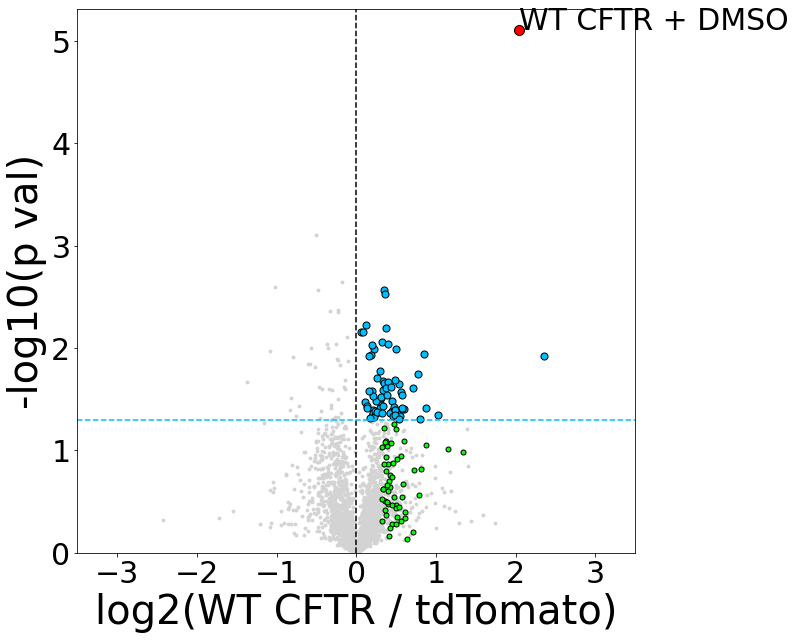

In [27]:
x = WT_DMSO_over_TD_2plot['avg']
y = WT_DMSO_over_TD_2plot['-log10 p_val']

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 40
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'lightgrey', s=8)

plt.vlines((0), 0, max(y+0.2), ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y+0.2))
WT_DMSO_interactors = []


for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
        WT_DMSO_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], 'WT CFTR + DMSO', size=fontsize-10, color ='k')
        #else: 
            #plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-25)
            #print('Sabusap: ' + str(data2.iloc[i[0]]['Gene Name'])[:6])

    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
        plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
        upregulted_former_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        #print('Pankow and Hutt: ' + str(data2.iloc[i[0]]['Gene Name'])[:6])

plt.xlabel('log2(WT CFTR / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-10)
plt.ylabel('-log10(p val)', size=fontsize)
plt.yticks(size=fontsize-10)

#plt.savefig('../Figures/WT_CFTR_DMSO_volcano_plot.svg', format='svg')

In [28]:
len(upregulted_former_interactors)

54

# WT CFTR + VX809

In [29]:
TD_tom = np.log2(data3[mock])

In [30]:
WT_CFTR_VX809 = np.log2(data3[WT_VX809])

In [31]:
WT_VX809_mocks = get_mock_runs(WT_CFTR_VX809, TD_tom, 1)
WT_VX809_over_TD = pd.DataFrame(WT_CFTR_VX809.values - WT_VX809_mocks.values)

In [32]:
stat_vals_WT_VX809 = stats.ttest_rel(WT_CFTR_VX809.values,  WT_VX809_mocks.values, axis=1, nan_policy= 'omit', alternative='two-sided')

In [33]:
## filter out any proteins which were not identified in at least 3 runs 
WT_VX809_over_TD_2plot = pd.DataFrame()
WT_VX809_over_TD_2plot['nans'] = WT_VX809_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(WT_VX809_over_TD_2plot['nans']):
    if val > len(WT_VX809_over_TD.columns)-2:
        drop_rows.append(i)
        
WT_VX809_over_TD = WT_VX809_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' + str(len(WT_VX809_over_TD)))

the number of interactors left = 1666


In [34]:
WT_VX809_over_TD_2plot = pd.DataFrame()
WT_VX809_over_TD_2plot['avg'] = WT_VX809_over_TD.mean(axis=1)
WT_VX809_over_TD_2plot['med'] = WT_VX809_over_TD.median(axis=1)
WT_VX809_over_TD_2plot['std'] = WT_VX809_over_TD.std(axis=1)
WT_VX809_over_TD_2plot['sum'] = WT_VX809_over_TD.sum(axis=1)
WT_VX809_over_TD_2plot['sum'] = WT_VX809_over_TD_2plot['sum'].replace(0.0, np.nan)
WT_VX809_over_TD_2plot['pvals'] = np.delete(np.array(stat_vals_WT_VX809[1]), drop_rows)
WT_VX809_over_TD_2plot['-log10 p_val'] = -np.log10(WT_VX809_over_TD_2plot['pvals'])
#WT_VX809_over_TD_2plot['-log10 p_val'] = WT_VX809_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

In [35]:
'''
# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(WT_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(WT_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)
'''

"\n# plot the distribution of the average and stddev of the log fold changes\nfig, ax = plt.subplots(1,2, figsize=(12,4))\nbin_num =50\nax[0].hist(WT_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')\nax[0].set_title('Distribution of average log2(FC)',fontsize=15)\nax[1].hist(WT_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')\nax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)\n"

In [36]:
'''
## plot a histogram of the p values 
plt.hist(WT_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()
'''

"\n## plot a histogram of the p values \nplt.hist(WT_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')\nplt.xlabel('p value', fontsize=20)\nplt.ylabel('Frequency', fontsize=20)\nplt.show()\n"

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 <a list of 10 Text major ticklabel objects>)

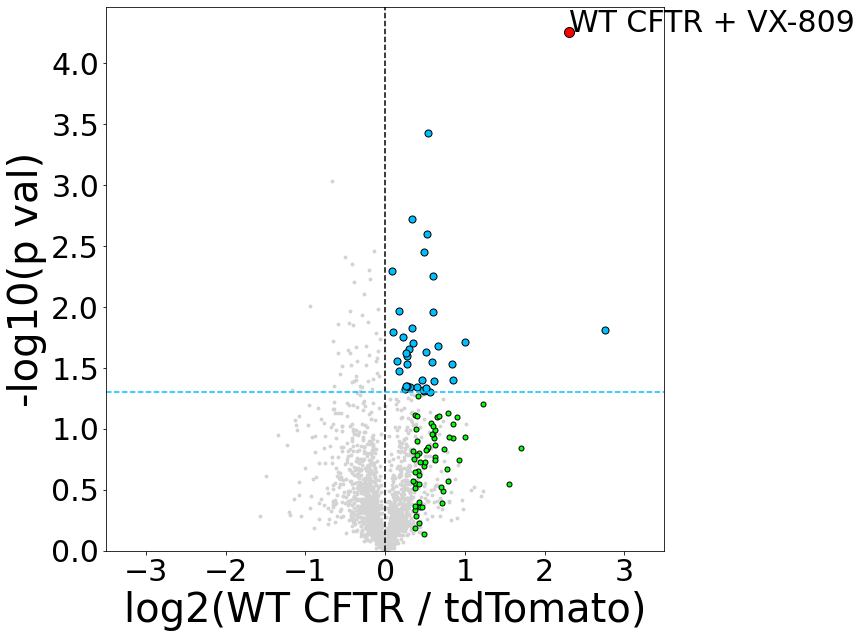

In [37]:
x = WT_VX809_over_TD_2plot['avg']
y = WT_VX809_over_TD_2plot['-log10 p_val']

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 40
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'lightgrey', s=8)

plt.vlines((0), 0, max(y)+0.2, ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y+0.2))
WT_VX809_interactors = []
for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
        WT_VX809_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]],'WT CFTR + VX-809', size=fontsize-10, color ='k')
        #else: 
         #   plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-20)
            #print(str(data2.iloc[i[0]]['Gene Name'])[:6])
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
        plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
        upregulted_former_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
plt.xlabel('log2(WT CFTR / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-10)
plt.ylabel('-log10(p val)', size=fontsize)
plt.yticks(size=fontsize-10)
#plt.savefig('../Figures/WT_CFTR_VX809_volcano_plot.svg', format='svg')

In [38]:
len(WT_VX809_interactors)

37

In [39]:
len(set(upregulted_former_interactors))

99

# F508del CFTR + DMSO

In [40]:
TD_tom = np.log2(data3[mock])

In [41]:
F508del_CFTR_DMSO = np.log2(data3[F508del_DMSO])

In [42]:
F508del_DMSO_mocks = get_mock_runs(F508del_CFTR_DMSO, TD_tom,0)
F508del_DMSO_over_TD = pd.DataFrame(F508del_CFTR_DMSO.values - F508del_DMSO_mocks.values)

In [43]:
F508del_stat_vals_DMSO = stats.ttest_rel(F508del_CFTR_DMSO.values, F508del_DMSO_mocks.values, axis=1, nan_policy= 'omit')

In [44]:
## filter out any proteins which were not identified in at least 3 runs 
F508del_DMSO_over_TD_2plot = pd.DataFrame()
F508del_DMSO_over_TD_2plot['nans'] = F508del_DMSO_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(F508del_DMSO_over_TD_2plot['nans']):
    if val >len(F508del_DMSO_over_TD.columns)-2:
        drop_rows.append(i)
        
F508del_DMSO_over_TD = F508del_DMSO_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(F508del_DMSO_over_TD)))

the number of interactors left = 1487


In [45]:
## calculate some statistical properties...
F508del_DMSO_over_TD_2plot = pd.DataFrame()
F508del_DMSO_over_TD_2plot['avg'] = F508del_DMSO_over_TD.mean(axis=1)
F508del_DMSO_over_TD_2plot['med'] = F508del_DMSO_over_TD.median(axis=1)
F508del_DMSO_over_TD_2plot['std'] = F508del_DMSO_over_TD.std(axis=1)
F508del_DMSO_over_TD_2plot['pvals'] = np.delete(np.array(F508del_stat_vals_DMSO[1]), drop_rows)
F508del_DMSO_over_TD_2plot['-log10 p_val'] = -np.log10(F508del_DMSO_over_TD_2plot['pvals'])
#F508del_DMSO_over_TD_2plot['-log10 p_val'] = F508del_DMSO_over_TD_2plot['-log10 p_val'].replace(-1.0, np.nan)

In [46]:
'''
# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(F508del_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(F508del_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)
'''

"\n# plot the distribution of the average and stddev of the log fold changes\nfig, ax = plt.subplots(1,2, figsize=(12,4))\nbin_num =50\nax[0].hist(F508del_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')\nax[0].set_title('Distribution of average log2(FC)',fontsize=15)\nax[1].hist(F508del_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')\nax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)\n"

In [47]:
'''
## plot a histogram of the p values 
plt.hist(F508del_DMSO_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()
'''

"\n## plot a histogram of the p values \nplt.hist(F508del_DMSO_over_TD_2plot['pvals'], bins=30, color = 'k')\nplt.xlabel('p value', fontsize=20)\nplt.ylabel('Frequency', fontsize=20)\nplt.show()\n"

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text major ticklabel objects>)

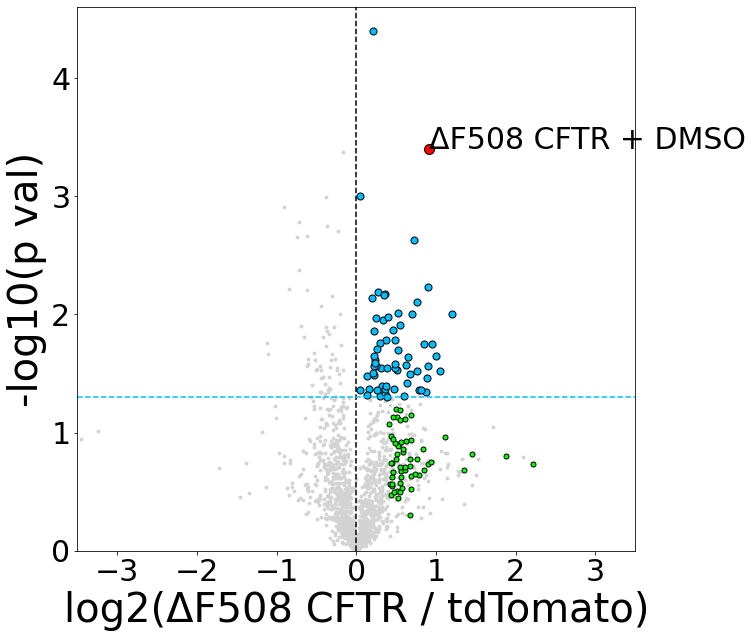

In [48]:
x = F508del_DMSO_over_TD_2plot['avg']
y = F508del_DMSO_over_TD_2plot['-log10 p_val']

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 40
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'lightgrey', s=8)

plt.vlines((0), 0, max(y)+0.2, ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y)+0.2)
F508del_DMSO_interactors =[]
for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
        F508del_DMSO_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], '\u0394F508 CFTR + DMSO', size=fontsize-10, color ='k')
        #else: 
         #   plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-20)
            #print(str(data2.iloc[i[0]]['Gene Name'])[:6])
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
        plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
        upregulted_former_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
      
            

plt.xlabel('log2(\u0394F508 CFTR / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-10)
plt.ylabel('-log10(p val)', size=fontsize)
plt.yticks(size=fontsize-10)
#plt.savefig('../Figures/F508del_CFTR_DSMO_volcano_plot.svg', format='svg')

In [49]:
len(F508del_DMSO_interactors)

64

In [50]:
len(set(upregulted_former_interactors))

125

# F508del CFTR + VX809

In [51]:
TD_tom = np.log2(data3[mock])

In [52]:
F508del_CFTR_VX809 = np.log2(data3[F508del_VX809])

In [53]:
F508del_VX809_mocks = get_mock_runs(F508del_CFTR_VX809, TD_tom,0)
F508del_VX809_over_TD = pd.DataFrame(F508del_CFTR_VX809.values - F508del_VX809_mocks.values)

In [54]:
F508del_stat_vals_VX809 = stats.ttest_rel(F508del_CFTR_VX809.values,  F508del_VX809_mocks.values, axis=1, nan_policy= 'omit')

In [55]:
## filter out any proteins which were not identified in at least 3 runs 
F508del_VX809_over_TD_2plot = pd.DataFrame()
F508del_VX809_over_TD_2plot['nans'] = F508del_VX809_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(F508del_VX809_over_TD_2plot['nans']):
    if val >len(F508del_VX809_over_TD.columns)-2:
        drop_rows.append(i)
        
F508del_VX809_over_TD = F508del_VX809_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(F508del_VX809_over_TD)))

the number of interactors left = 1486


In [56]:
F508del_VX809_over_TD_2plot = pd.DataFrame()
F508del_VX809_over_TD_2plot['avg'] = F508del_VX809_over_TD.mean(axis=1)
F508del_VX809_over_TD_2plot['std'] = F508del_VX809_over_TD.std(axis=1)
F508del_VX809_over_TD_2plot['med'] = F508del_VX809_over_TD.median(axis=1)
F508del_VX809_over_TD_2plot['sum'] = F508del_VX809_over_TD.sum(axis=1)
F508del_VX809_over_TD_2plot['sum'] = F508del_VX809_over_TD_2plot['sum'].replace(0.0, np.nan)
F508del_VX809_over_TD_2plot['pvals'] = np.delete(F508del_stat_vals_VX809[1], drop_rows)
F508del_VX809_over_TD_2plot['-log10 p_val'] = -np.log10(F508del_VX809_over_TD_2plot['pvals'])

In [57]:
'''
# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(F508del_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(F508del_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)
'''

"\n# plot the distribution of the average and stddev of the log fold changes\nfig, ax = plt.subplots(1,2, figsize=(12,4))\nbin_num =50\nax[0].hist(F508del_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')\nax[0].set_title('Distribution of average log2(FC)',fontsize=15)\nax[1].hist(F508del_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')\nax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)\n"

In [58]:
'''
## plot a histogram of the p values 
plt.hist(F508del_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()
'''

"\n## plot a histogram of the p values \nplt.hist(F508del_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')\nplt.xlabel('p value', fontsize=20)\nplt.ylabel('Frequency', fontsize=20)\nplt.show()\n"

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text major ticklabel objects>)

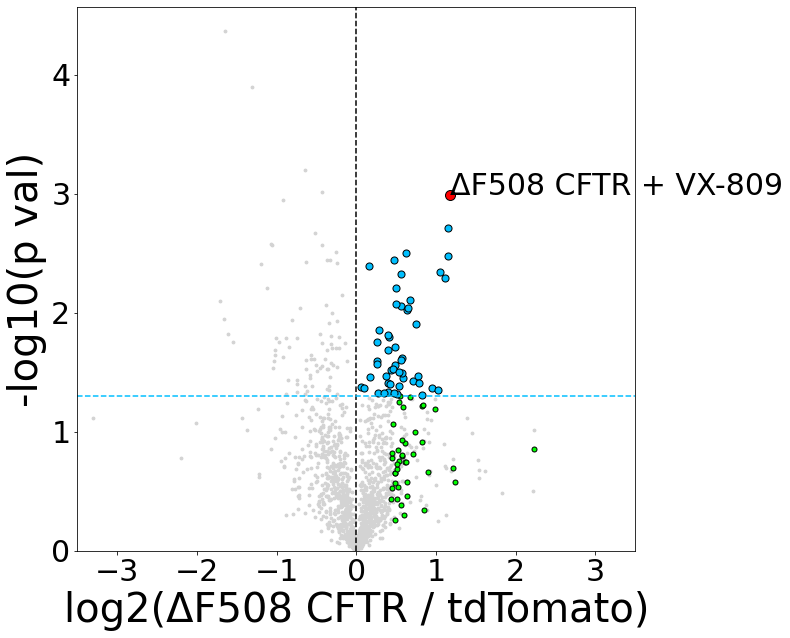

In [59]:
x = F508del_VX809_over_TD_2plot['avg']
y = F508del_VX809_over_TD_2plot['-log10 p_val']

x = x.replace(np.inf, np.nan)
y = y.replace(np.inf, np.nan)

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 40
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'lightgrey', s=8)

plt.vlines((0), 0, max(y)+0.2, ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y)+0.2)
F508del_VX809_interactors =[]
for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
        F508del_VX809_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], '\u0394F508 CFTR + VX-809', size=fontsize-10, color ='k')
        #else: 
         #   plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-20)
            #print(str(data2.iloc[i[0]]['Gene Name'])[:6])
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
        plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
        upregulted_former_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
            

plt.xlabel('log2(\u0394F508 CFTR / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-10)
plt.ylabel('-log10(p val)', size=fontsize)
plt.yticks(size=fontsize-10)
#plt.savefig('../Figures/F508del_CFTR_VX809_volcano_plot.svg', format='svg')

In [60]:
len(F508del_VX809_interactors)

50

In [61]:
len(set(upregulted_former_interactors))

135

## P67L CFTR + DMSO

In [62]:
TD_tom = np.log2(data3[mock])

In [63]:
P67L_CFTR_DMSO = np.log2(data3[P67L_DMSO])

In [64]:
P67L_DMSO_mocks = get_mock_runs(P67L_CFTR_DMSO, TD_tom,0)
P67L_DMSO_over_TD = pd.DataFrame(P67L_CFTR_DMSO.values - P67L_DMSO_mocks.values)

In [65]:
P67L_stat_vals_DMSO = stats.ttest_rel(P67L_CFTR_DMSO.values, P67L_DMSO_mocks.values, axis=1, nan_policy= 'omit')

In [66]:
## filter out any proteins which were not identified in at least 3 runs 
P67L_DMSO_over_TD_2plot = pd.DataFrame()
P67L_DMSO_over_TD_2plot['nans'] =P67L_DMSO_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(P67L_DMSO_over_TD_2plot['nans']):
    if val > len(P67L_DMSO_over_TD.columns)-2:
        drop_rows.append(i)
        
P67L_DMSO_over_TD = P67L_DMSO_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(P67L_DMSO_over_TD)))

the number of interactors left = 1778


In [67]:
P67L_DMSO_over_TD_2plot = pd.DataFrame()
P67L_DMSO_over_TD_2plot['avg'] = P67L_DMSO_over_TD.mean(axis=1)
P67L_DMSO_over_TD_2plot['med'] = P67L_DMSO_over_TD.median(axis=1)
P67L_DMSO_over_TD_2plot['std'] = P67L_DMSO_over_TD.std(axis=1)
P67L_DMSO_over_TD_2plot['pvals'] = np.delete(np.array(P67L_stat_vals_DMSO[1]), drop_rows)
P67L_DMSO_over_TD_2plot['-log10 p_val'] = -np.log10(P67L_DMSO_over_TD_2plot['pvals'])

In [68]:
'''
# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(P67L_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(P67L_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)
'''

"\n# plot the distribution of the average and stddev of the log fold changes\nfig, ax = plt.subplots(1,2, figsize=(12,4))\nbin_num =50\nax[0].hist(P67L_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')\nax[0].set_title('Distribution of average log2(FC)',fontsize=15)\nax[1].hist(P67L_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')\nax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)\n"

In [69]:
'''
## plot a histogram of the p values 
plt.hist(P67L_DMSO_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()'''

"\n## plot a histogram of the p values \nplt.hist(P67L_DMSO_over_TD_2plot['pvals'], bins=30, color = 'k')\nplt.xlabel('p value', fontsize=20)\nplt.ylabel('Frequency', fontsize=20)\nplt.show()"

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 <a list of 9 Text major ticklabel objects>)

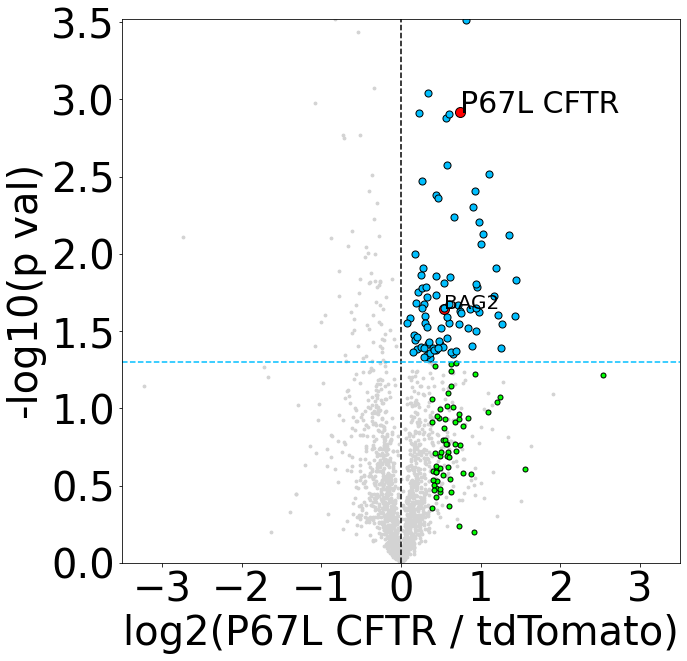

In [70]:
x = P67L_DMSO_over_TD_2plot['avg']
y = P67L_DMSO_over_TD_2plot['-log10 p_val']

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 40
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'lightgrey', s=8)

plt.vlines((0), 0, max(y), ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))
P67L_DMSO_interactors =[]
for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
        P67L_DMSO_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], 'P67L CFTR', size=fontsize-10, color ='k')
            
        if data2.iloc[i[0]]['Gene Name'] == 'BAG2':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], 'BAG2', size=fontsize-20, color ='k')
        #else: 
         #   plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-20)
            #print("Sabusap: " + str(data2.iloc[i[0]]['Gene Name'])[:6])
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
        plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
        upregulted_former_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        #print("Pankow and Hutt: " + str(data2.iloc[i[0]]['Gene Name'])[:6])

plt.xlabel('log2(P67L CFTR / tdTomato)', size=fontsize)
plt.xticks(size=fontsize)
plt.ylabel('-log10(p val)', size=fontsize)
plt.yticks(size=fontsize)
#plt.savefig('../Figures/P67L_CFTR_DMSO_volcano_plot_BAG2.svg', format='svg')

In [71]:
len(set(upregulted_former_interactors))

151

In [72]:
'''
F508del_P67L_venn_dict = {}
F508del_P67L_venn_dict['WT'] = set(WT_DMSO_interactors)
F508del_P67L_venn_dict['F508del'] = set(F508del_DMSO_interactors)
F508del_P67L_venn_dict['P67L'] = set(P67L_DMSO_interactors)
'''

"\nF508del_P67L_venn_dict = {}\nF508del_P67L_venn_dict['WT'] = set(WT_DMSO_interactors)\nF508del_P67L_venn_dict['F508del'] = set(F508del_DMSO_interactors)\nF508del_P67L_venn_dict['P67L'] = set(P67L_DMSO_interactors)\n"

In [73]:
'''venn(F508del_P67L_venn_dict, cmap=['deepskyblue', 'r','lime'], fontsize=30)
plt.savefig('../Figures/F508del_P67L__DMSO_venn_diagram.svg', format='svg')'''

"venn(F508del_P67L_venn_dict, cmap=['deepskyblue', 'r','lime'], fontsize=30)\nplt.savefig('../Figures/F508del_P67L__DMSO_venn_diagram.svg', format='svg')"

# P67L CFTR + VX-809

In [74]:
TD_tom = np.log2(data3[mock])

In [75]:
P67L_CFTR_VX809 = np.log2(data3[P67L_VX809])

In [76]:
P67L_VX809_mocks = get_mock_runs(P67L_CFTR_VX809, TD_tom,0)
P67L_VX809_over_TD = pd.DataFrame(P67L_CFTR_VX809.values - P67L_VX809_mocks.values)

In [77]:
P67L_stat_vals_VX809 = stats.ttest_rel(P67L_CFTR_VX809.values,  P67L_VX809_mocks.values, axis=1, nan_policy= 'omit')

In [78]:
## filter out any proteins which were not identified in at least 3 runs 
P67L_VX809_over_TD_2plot = pd.DataFrame()
P67L_VX809_over_TD_2plot['nans'] = P67L_VX809_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(P67L_VX809_over_TD_2plot['nans']):
    if val > len(P67L_VX809_over_TD.columns)-2:
        drop_rows.append(i)
        
P67L_VX809_over_TD = P67L_VX809_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(P67L_VX809_over_TD)))

the number of interactors left = 1778


In [79]:
P67L_VX809_over_TD_2plot = pd.DataFrame()
P67L_VX809_over_TD_2plot['avg'] = P67L_VX809_over_TD.mean(axis=1)
P67L_VX809_over_TD_2plot['med'] = P67L_VX809_over_TD.median(axis=1)
P67L_VX809_over_TD_2plot['std'] = P67L_VX809_over_TD.std(axis=1)
P67L_VX809_over_TD_2plot['pvals'] = np.delete(np.array(P67L_stat_vals_VX809[1]), drop_rows)
P67L_VX809_over_TD_2plot['-log10 p_val'] = -np.log10(P67L_VX809_over_TD_2plot['pvals'])

In [80]:
'''# plot the distribution of the average and stddev of the log fold changes
fig, ax = plt.subplots(1,2, figsize=(12,4))
bin_num =50
ax[0].hist(P67L_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')
ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
ax[1].hist(P67L_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')
ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)'''

"# plot the distribution of the average and stddev of the log fold changes\nfig, ax = plt.subplots(1,2, figsize=(12,4))\nbin_num =50\nax[0].hist(P67L_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')\nax[0].set_title('Distribution of average log2(FC)',fontsize=15)\nax[1].hist(P67L_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')\nax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)"

In [81]:
'''## plot a histogram of the p values 
plt.hist(P67L_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()'''

"## plot a histogram of the p values \nplt.hist(P67L_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')\nplt.xlabel('p value', fontsize=20)\nplt.ylabel('Frequency', fontsize=20)\nplt.show()"

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 <a list of 10 Text major ticklabel objects>)

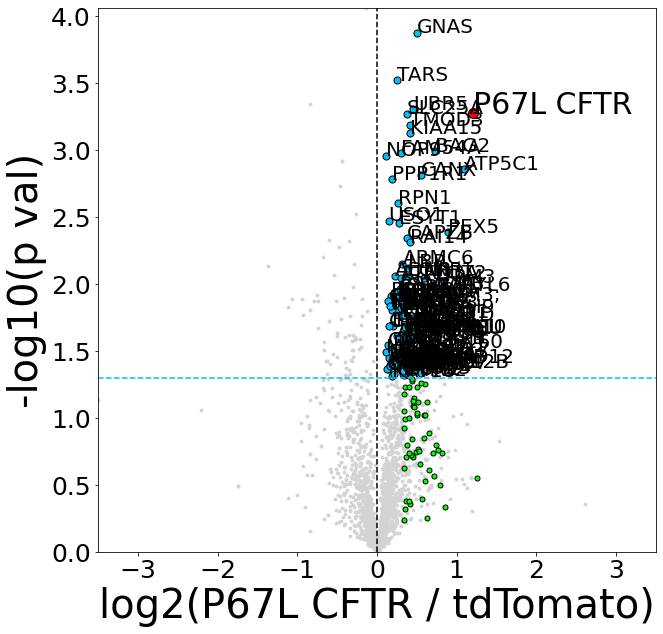

In [82]:
x = P67L_VX809_over_TD_2plot['avg']
y = P67L_VX809_over_TD_2plot['-log10 p_val']

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 40
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'lightgrey', s=8)

plt.vlines((0), 0, max(y), ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))
P67L_VX809_interactors =[]
for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
        P67L_VX809_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], 'P67L CFTR', size=fontsize-10, color ='k')
        else: 
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-20)
            #print("Sabusap: " + str(data2.iloc[i[0]]['Gene Name'])[:6])
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
        plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
        upregulted_former_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        #rint("Pankow and Hutt: " + str(data2.iloc[i[0]]['Gene Name'])[:6])

plt.xlabel('log2(P67L CFTR / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-15)
plt.ylabel('-log10(p val)', size=fontsize)
plt.yticks(size=fontsize-15)
#plt.savefig('../Figures/P67L_CFTR_VX809_volcano_plot.svg', format='svg')

In [83]:
len(P67L_VX809_interactors)

104

In [84]:
len(set(upregulted_former_interactors))

170

In [85]:
'''VX809_F508del_P67L_venn_dict = {}
VX809_F508del_P67L_venn_dict['WT + DMSO'] = set(WT_DMSO_interactors)
VX809_F508del_P67L_venn_dict['P67L + DMSO'] = set(P67L_DMSO_interactors)
VX809_F508del_P67L_venn_dict['P67L + VX-809'] = set(P67L_VX809_interactors)
#VX809_F508del_P67L_venn_dict['F508del + DMSO'] = set(F508del_DMSO_interactors)
#VX809_F508del_P67L_venn_dict['F508del + VX-809'] = set(F508del_VX809_interactors)

#VX809_F508del_P67L_venn_dict['WT + VX-809'] = set(WT_VX809_interactors)'''

"VX809_F508del_P67L_venn_dict = {}\nVX809_F508del_P67L_venn_dict['WT + DMSO'] = set(WT_DMSO_interactors)\nVX809_F508del_P67L_venn_dict['P67L + DMSO'] = set(P67L_DMSO_interactors)\nVX809_F508del_P67L_venn_dict['P67L + VX-809'] = set(P67L_VX809_interactors)\n#VX809_F508del_P67L_venn_dict['F508del + DMSO'] = set(F508del_DMSO_interactors)\n#VX809_F508del_P67L_venn_dict['F508del + VX-809'] = set(F508del_VX809_interactors)\n\n#VX809_F508del_P67L_venn_dict['WT + VX-809'] = set(WT_VX809_interactors)"

In [86]:
'''venn(VX809_F508del_P67L_venn_dict, cmap=['deepskyblue', 'lime','darkorchid', ],fontsize=30)
plt.savefig('../Figures/P67L_VX809_WT_venn_diagram.svg', format='svg')'''

"venn(VX809_F508del_P67L_venn_dict, cmap=['deepskyblue', 'lime','darkorchid', ],fontsize=30)\nplt.savefig('../Figures/P67L_VX809_WT_venn_diagram.svg', format='svg')"

# L206W + DMSO

In [87]:
TD_tom = np.log2(data3[mock])

In [88]:
L206W_CFTR_DMSO = np.log2(data3[L206W_DMSO])

In [89]:
L206W_DMSO_mocks = get_mock_runs(L206W_CFTR_DMSO, TD_tom,0)
L206W_DMSO_over_TD = pd.DataFrame(L206W_CFTR_DMSO.values - L206W_DMSO_mocks.values)

In [90]:
L206W_stat_vals_DMSO = stats.ttest_rel(L206W_CFTR_DMSO.values, L206W_DMSO_mocks.values, axis=1, nan_policy= 'omit')

In [91]:
# filter out any proteins which were not identified in at least 3 runs 
L206W_DMSO_over_TD_2plot = pd.DataFrame()
L206W_DMSO_over_TD_2plot['nans'] = L206W_DMSO_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(L206W_DMSO_over_TD_2plot['nans']):
    if val > len(L206W_DMSO_over_TD.columns)-2:
        drop_rows.append(i)
        
L206W_DMSO_over_TD = L206W_DMSO_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(L206W_DMSO_over_TD)))

the number of interactors left = 2353


In [92]:
L206W_DMSO_over_TD_2plot = pd.DataFrame()
L206W_DMSO_over_TD_2plot['avg'] = L206W_DMSO_over_TD.mean(axis=1)
L206W_DMSO_over_TD_2plot['med'] = L206W_DMSO_over_TD.median(axis=1)
L206W_DMSO_over_TD_2plot['std'] = L206W_DMSO_over_TD.std(axis=1)
L206W_DMSO_over_TD_2plot['pvals'] = np.delete(np.array(L206W_stat_vals_DMSO[1]), drop_rows)
L206W_DMSO_over_TD_2plot['-log10 p_val'] = -np.log10(L206W_DMSO_over_TD_2plot['pvals'])


In [93]:
# plot the distribution of the average and stddev of the log fold changes
#fig, ax = plt.subplots(1,2, figsize=(12,4))
#bin_num =50
#ax[0].hist(L206W_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')
#ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
#ax[1].hist(L206W_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')
#ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)

In [94]:
'''## plot a histogram of the p values 
plt.hist(L206W_DMSO_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()'''

"## plot a histogram of the p values \nplt.hist(L206W_DMSO_over_TD_2plot['pvals'], bins=30, color = 'k')\nplt.xlabel('p value', fontsize=20)\nplt.ylabel('Frequency', fontsize=20)\nplt.show()"

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 <a list of 9 Text major ticklabel objects>)

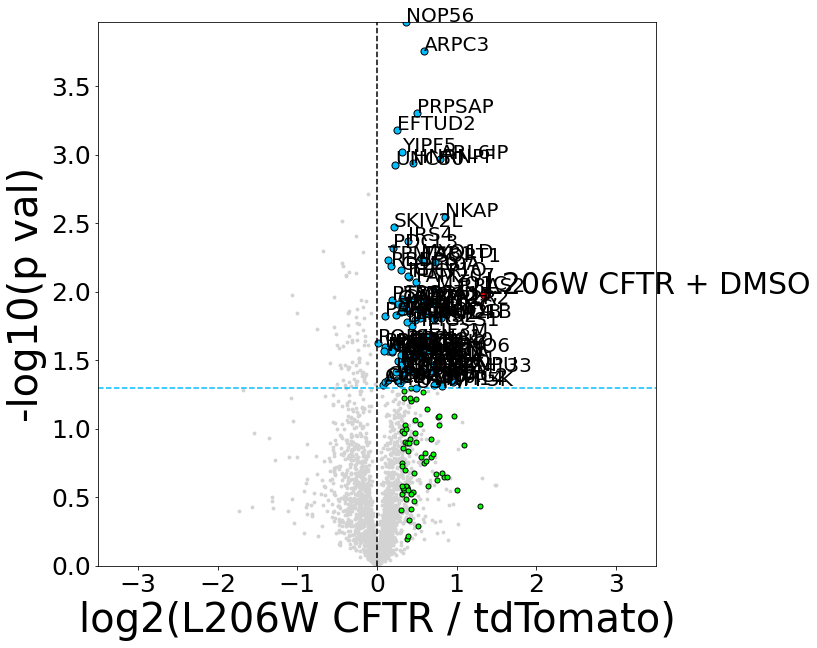

In [95]:
x = L206W_DMSO_over_TD_2plot['avg']
y = L206W_DMSO_over_TD_2plot['-log10 p_val']

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 40
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'lightgrey', s=8)

plt.vlines((0), 0, max(y), ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))
L206W_DMSO_interactors =[]
for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
        L206W_DMSO_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], 'L206W CFTR + DMSO', size=fontsize-10, color ='k')
        else: 
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-20)
            #print("Sabusap: " + str(data2.iloc[i[0]]['Gene Name'])[:6])
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
        plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
        upregulted_former_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        #rint("Pankow and Hutt: " + str(data2.iloc[i[0]]['Gene Name'])[:6])

plt.xlabel('log2(L206W CFTR / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-15)
plt.ylabel('-log10(p val)', size=fontsize)
plt.yticks(size=fontsize-15)
#plt.savefig('../Figures/L206W_CFTR_DMSO_volcano_plot.svg', format='svg')

In [96]:
len(L206W_DMSO_interactors)

86

In [97]:
len(set(upregulted_former_interactors))

196

# L206W + VX809

In [98]:
TD_tom = np.log2(data3[mock])

In [99]:
L206W_CFTR_VX809 = np.log2(data3[L206W_VX809])

In [100]:
L206W_VX809_mocks = get_mock_runs(L206W_CFTR_VX809, TD_tom,0)
L206W_VX809_over_TD = pd.DataFrame(L206W_CFTR_VX809.values - L206W_VX809_mocks.values)

In [101]:
L206W_stat_vals_VX809 = stats.ttest_rel(L206W_CFTR_VX809.values, L206W_VX809_mocks.values, axis=1, nan_policy= 'omit')

In [102]:
# filter out any proteins which were not identified in at least 3 runs 
L206W_VX809_over_TD_2plot = pd.DataFrame()
L206W_VX809_over_TD_2plot['nans'] = L206W_VX809_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(L206W_VX809_over_TD_2plot['nans']):
    if val > len(L206W_VX809_over_TD.columns)-2:
        drop_rows.append(i)
        
L206W_VX809_over_TD = L206W_VX809_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(L206W_VX809_over_TD)))

the number of interactors left = 2357


In [103]:
L206W_VX809_over_TD_2plot = pd.DataFrame()
L206W_VX809_over_TD_2plot['avg'] = L206W_VX809_over_TD.mean(axis=1)
L206W_VX809_over_TD_2plot['med'] = L206W_VX809_over_TD.median(axis=1)
L206W_VX809_over_TD_2plot['std'] = L206W_VX809_over_TD.std(axis=1)
L206W_VX809_over_TD_2plot['pvals'] = np.delete(np.array(L206W_stat_vals_VX809[1]), drop_rows)
L206W_VX809_over_TD_2plot['-log10 p_val'] = -np.log10(L206W_VX809_over_TD_2plot['pvals'])

In [104]:
# plot the distribution of the average and stddev of the log fold changes
#fig, ax = plt.subplots(1,2, figsize=(12,4))
#bin_num =50
#ax[0].hist(L206W_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')
#ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
#ax[1].hist(L206W_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')
#ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)

In [105]:
'''## plot a histogram of the p values 
plt.hist(L206W_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()'''

"## plot a histogram of the p values \nplt.hist(L206W_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')\nplt.xlabel('p value', fontsize=20)\nplt.ylabel('Frequency', fontsize=20)\nplt.show()"

(array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ]),
 <a list of 9 Text major ticklabel objects>)

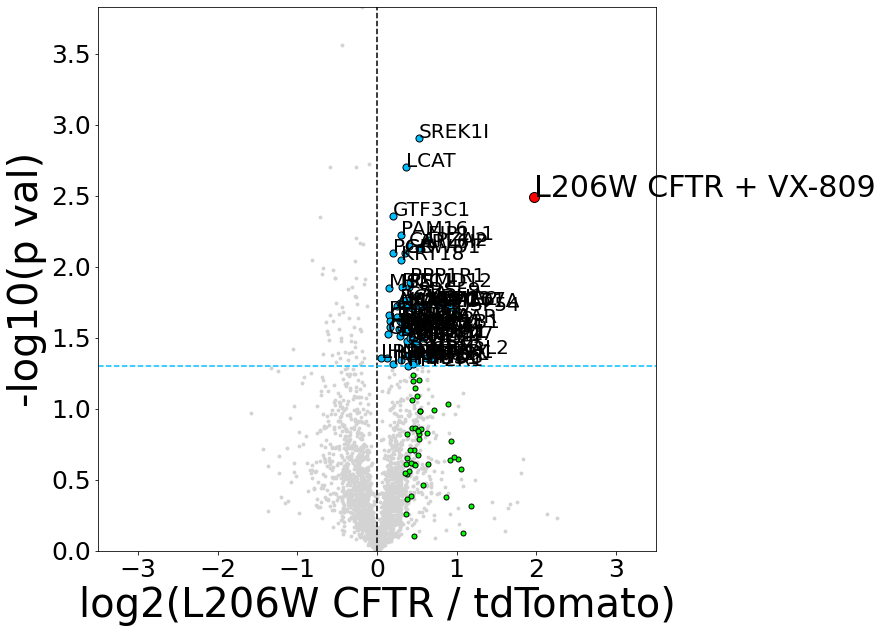

In [106]:
x = L206W_VX809_over_TD_2plot['avg']
y = L206W_VX809_over_TD_2plot['-log10 p_val']

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 40
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'lightgrey', s=8)

plt.vlines((0), 0, max(y), ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y))
L206W_VX809_interactors =[]
for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
        L206W_VX809_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], 'L206W CFTR + VX-809', size=fontsize-10, color ='k')
        else: 
            plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-20)
            #print("Sabusap: " + str(data2.iloc[i[0]]['Gene Name'])[:6])
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
        plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
        upregulted_former_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        #rint("Pankow and Hutt: " + str(data2.iloc[i[0]]['Gene Name'])[:6])

plt.xlabel('log2(L206W CFTR / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-15)
plt.ylabel('-log10(p val)', size=fontsize)
plt.yticks(size=fontsize-15)
#plt.savefig('../Figures/L206W_CFTR_VX809_volcano_plot.svg', format='svg')

In [107]:
len(L206W_VX809_interactors)

66

In [108]:
len(set(upregulted_former_interactors))

210

# G85E + DMSO

In [109]:
TD_tom = np.log2(data3[mock])

In [110]:
G85E_CFTR_DMSO = np.log2(data3[G85E_DMSO])

In [111]:
#drop the first G85E replicate in run 12 because CFTR did not show up as enriched on the western blot
G85E_CFTR_DMSO = G85E_CFTR_DMSO.drop(columns ='Run 12 G85E-DMSO')

In [112]:
G85E_DMSO_mocks = get_mock_runs(G85E_CFTR_DMSO, TD_tom,0)
G85E_DMSO_over_TD = pd.DataFrame(G85E_CFTR_DMSO.values - G85E_DMSO_mocks.values)

In [113]:
G85E_stat_vals_DMSO = stats.ttest_rel(G85E_CFTR_DMSO.values, G85E_DMSO_mocks.values, axis=1, nan_policy= 'omit')

In [114]:
# filter out any proteins which were not identified in at least 3 runs 
G85E_DMSO_over_TD_2plot = pd.DataFrame()
G85E_DMSO_over_TD_2plot['nans'] = G85E_DMSO_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(G85E_DMSO_over_TD_2plot['nans']):
    if val > len(G85E_DMSO_over_TD.columns)-2:
        drop_rows.append(i)
        
G85E_DMSO_over_TD = G85E_DMSO_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(G85E_DMSO_over_TD)))



the number of interactors left = 2409


In [115]:
G85E_DMSO_over_TD_2plot = pd.DataFrame()
G85E_DMSO_over_TD_2plot['avg'] = G85E_DMSO_over_TD.mean(axis=1)
G85E_DMSO_over_TD_2plot['med'] = G85E_DMSO_over_TD.median(axis=1)
G85E_DMSO_over_TD_2plot['std'] = G85E_DMSO_over_TD.std(axis=1)
G85E_DMSO_over_TD_2plot['pvals'] = np.delete(np.array(G85E_stat_vals_DMSO[1]), drop_rows)
G85E_DMSO_over_TD_2plot['-log10 p_val'] = -np.log10(G85E_DMSO_over_TD_2plot['pvals'])

In [116]:
# plot the distribution of the average and stddev of the log fold changes
#fig, ax = plt.subplots(1,2, figsize=(12,4))
#bin_num =50
#ax[0].hist(G85E_DMSO_over_TD_2plot['avg'], bins=bin_num, color='r')
#ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
#ax[1].hist(G85E_DMSO_over_TD_2plot['std'], bins=bin_num, color ='b')
#ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)

In [117]:
'''## plot a histogram of the p values 
plt.hist(G85E_DMSO_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()'''

"## plot a histogram of the p values \nplt.hist(G85E_DMSO_over_TD_2plot['pvals'], bins=30, color = 'k')\nplt.xlabel('p value', fontsize=20)\nplt.ylabel('Frequency', fontsize=20)\nplt.show()"

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text major ticklabel objects>)

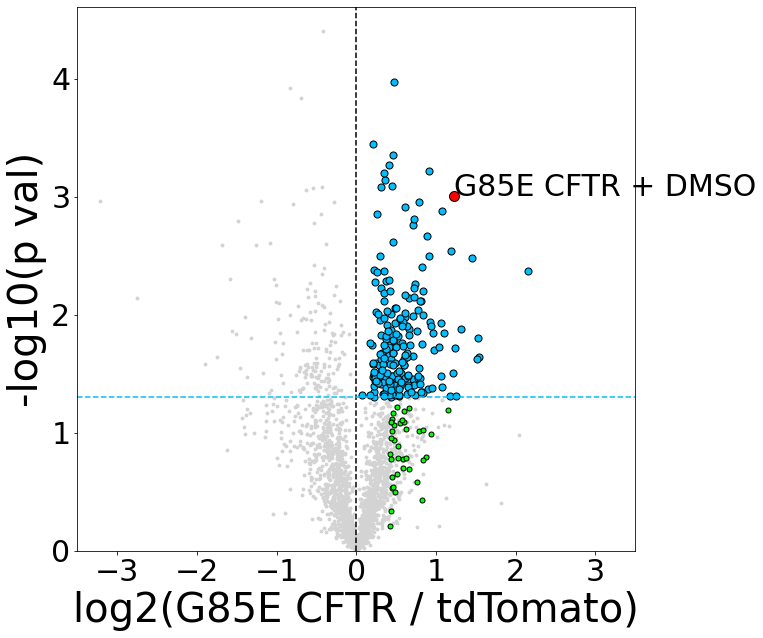

In [118]:
x = G85E_DMSO_over_TD_2plot['avg']
y = G85E_DMSO_over_TD_2plot['-log10 p_val']

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 40
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'lightgrey', s=8)

plt.vlines((0), 0, max(y)+0.2, ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y)+0.2)
G85E_DMSO_interactors =[]
for i in x.items(): 
   
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
        G85E_DMSO_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], 'G85E CFTR + DMSO', size=fontsize-10, color ='k')
        #else: 
         #   plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-20)
            #print("Sabusap: " + str(data2.iloc[i[0]]['Gene Name'])[:6])
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
        plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
        upregulted_former_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        #rint("Pankow and Hutt: " + str(data2.iloc[i[0]]['Gene Name'])[:6])

plt.xlabel('log2(G85E CFTR / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-10)
plt.ylabel('-log10(p val)', size=fontsize)
plt.yticks(size=fontsize-10)
#plt.savefig('../Figures/G85E_CFTR_DMSO_volcano_plot.svg', format='svg')

In [119]:
len(G85E_DMSO_interactors)

209

# G85E + VX-809

In [120]:
TD_tom = np.log2(data3[mock])

In [121]:
G85E_CFTR_VX809 = np.log2(data3[G85E_VX809])

In [122]:
#drop the first G85E replicate in run 12 because CFTR did not show up as enriched on the western blot
G85E_CFTR_VX809 = G85E_CFTR_VX809.drop(columns ='Run 12 G85E-VX809')

In [123]:
G85E_VX809_mocks = get_mock_runs(G85E_CFTR_VX809, TD_tom,0)
G85E_VX809_over_TD = pd.DataFrame(G85E_CFTR_VX809.values - G85E_VX809_mocks.values)

In [124]:
G85E_stat_vals_VX809 = stats.ttest_rel(G85E_CFTR_VX809.values, G85E_VX809_mocks.values, axis=1, nan_policy= 'omit')

In [125]:
# filter out any proteins which were not identified in at least 3 runs 
G85E_VX809_over_TD_2plot = pd.DataFrame()
G85E_VX809_over_TD_2plot['nans'] = G85E_VX809_over_TD.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(G85E_VX809_over_TD_2plot['nans']):
    if val > len(G85E_VX809_over_TD.columns)-2:
        drop_rows.append(i)
        
G85E_VX809_over_TD = G85E_VX809_over_TD.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(G85E_VX809_over_TD)))



the number of interactors left = 2409


In [126]:
G85E_VX809_over_TD_2plot = pd.DataFrame()
G85E_VX809_over_TD_2plot['avg'] = G85E_VX809_over_TD.mean(axis=1)
G85E_VX809_over_TD_2plot['med'] = G85E_VX809_over_TD.median(axis=1)
G85E_VX809_over_TD_2plot['std'] = G85E_VX809_over_TD.std(axis=1)
G85E_VX809_over_TD_2plot['pvals'] = np.delete(np.array(G85E_stat_vals_VX809[1]), drop_rows)
G85E_VX809_over_TD_2plot['-log10 p_val'] = -np.log10(G85E_VX809_over_TD_2plot['pvals'])

In [127]:
# plot the distribution of the average and stddev of the log fold changes
#fig, ax = plt.subplots(1,2, figsize=(12,4))
#bin_num =50
#ax[0].hist(G85E_VX809_over_TD_2plot['avg'], bins=bin_num, color='r')
#ax[0].set_title('Distribution of average log2(FC)',fontsize=15)
#ax[1].hist(G85E_VX809_over_TD_2plot['std'], bins=bin_num, color ='b')
#ax[1].set_title('Distribution of standard deviation log2(FC)',fontsize=15)

In [128]:
'''## plot a histogram of the p values 
plt.hist(G85E_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')
plt.xlabel('p value', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.show()'''

"## plot a histogram of the p values \nplt.hist(G85E_VX809_over_TD_2plot['pvals'], bins=30, color = 'k')\nplt.xlabel('p value', fontsize=20)\nplt.ylabel('Frequency', fontsize=20)\nplt.show()"

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text major ticklabel objects>)

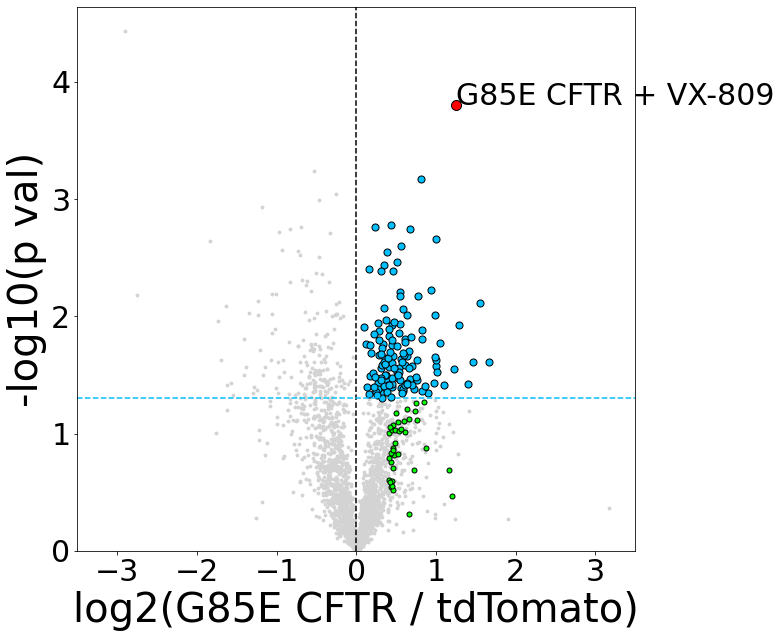

In [129]:
x = G85E_VX809_over_TD_2plot['avg']
y = G85E_VX809_over_TD_2plot['-log10 p_val']

cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 40
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = 'lightgrey', s=8)

plt.vlines((0), 0, max(y)+0.2, ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'deepskyblue')
plt.xlim(-rng,rng)
plt.ylim(0,max(y)+0.2)
G85E_VX809_interactors =[]
for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0: #y[i[0]] >= c/(x[i[0]]-x_std) and x[i[0]] >= x_std: 
        plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
        G85E_VX809_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], 'G85E CFTR + VX-809', size=fontsize-10, color ='k')
        #else: 
         #   plt.text(x[i[0]],y[i[0]], str(data2.iloc[i[0]]['Gene Name'])[:6], size=fontsize-20)
            #print("Sabusap: " + str(data2.iloc[i[0]]['Gene Name'])[:6])
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
        plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
        upregulted_former_interactors.append(str(data2.iloc[i[0]]['Gene Name']))
        #rint("Pankow and Hutt: " + str(data2.iloc[i[0]]['Gene Name'])[:6])

plt.xlabel('log2(G85E CFTR / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-10)
plt.ylabel('-log10(p val)', size=fontsize)
plt.yticks(size=fontsize-10)
#plt.savefig('../Figures/G85E_CFTR_VX809_volcano_plot.svg', format='svg')

In [130]:
len(G85E_VX809_interactors)

136

In [131]:
len(set(upregulted_former_interactors))

234

In [132]:
Hutt_G85E = pd.read_excel('./Hutt_G85E_CFTR_interactome.xlsx', sheet_name='FC pval G85E vs GFP')


In [133]:
G85E_venn_dict = {}
G85E_venn_dict['Hutt'] = set(Hutt_G85E['Genenames'])
G85E_venn_dict['Sabusap'] = set(np.concatenate([G85E_DMSO_interactors,G85E_VX809_interactors ]))



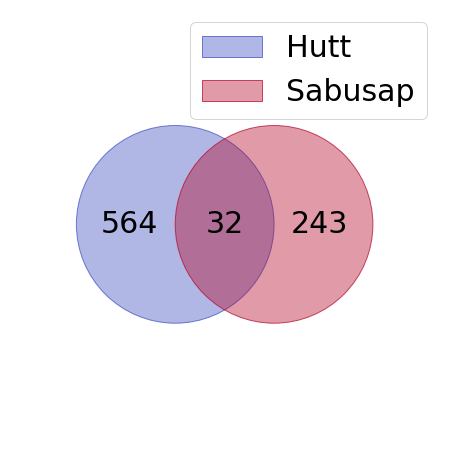

In [134]:
venn(G85E_venn_dict, cmap='coolwarm', fontsize=30)
#plt.savefig('../Figures/G85E_venn_diagram.svg', format='svg')

## Plot Interactors Overlap

In [135]:
Sabusap_core_interactome = np.concatenate(  [WT_DMSO_interactors, WT_VX809_interactors,
                                    F508del_DMSO_interactors, F508del_VX809_interactors,
                                    L206W_DMSO_interactors, L206W_VX809_interactors, 
                                    G85E_DMSO_interactors, G85E_VX809_interactors])

In [136]:
len(set(Sabusap_core_interactome))

509

In [137]:
Hutt_G85E = pd.read_excel('./Hutt_G85E_CFTR_interactome.xlsx')

In [138]:
len(set(Hutt_core_interactome2))

NameError: name 'Hutt_core_interactome2' is not defined

In [139]:
Hutt_core_interactome2 = np.concatenate([Hutt_core_interactome, np.array(Hutt_G85E['Proteins'])])

In [140]:
Pankow_core_interactome = Pankow_CFTR_core['Official Gene symbol']

In [141]:
core_venn_dict = {}
core_venn_dict['McDonald, Sabusap'] = set(Sabusap_core_interactome)
core_venn_dict['Pankow'] = set(Pankow_core_interactome)
core_venn_dict['Hutt'] = set(Hutt_core_interactome)

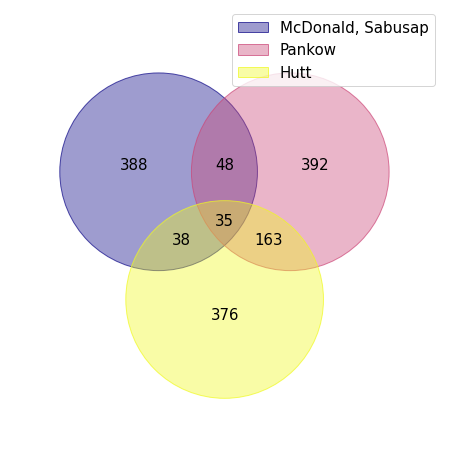

In [142]:
venn(core_venn_dict, cmap='plasma', fontsize=15)
#plt.savefig('../Figures/Sabusap_Pankow_Hutt_venn_diagram.svg', format='svg')

In [143]:
McDonald_core_interactome = set(Sabusap_core_interactome)

In [144]:
overlap = []
for i in McDonald_core_interactome:
    #print(i)
    if i in list(Pankow_core_interactome) and i in Hutt_core_interactome:
        print(i)
        overlap.append(i)

PCBP2
ESYT2
MYO1B
KRT18
CANX
MYH14
XPNPEP3
PSMD12
TAGLN2
PPP2R2A
ATP5A1
TPM2
ARPC2
MYO6
MYO1C
TECR
CAPZB
MYL9
KPNB1
MYO1D
CAPZA1
PRDX1
IPO9
RPLP0
ARPC5L
DAZAP1
LMNB1
SEC61A1
LIMA1
TMOD3
PPP2R1A
PHB
TPM4
CAPZA2
MYO18A


In [145]:
len(overlap)

35

## All variants + DMSO and VX-809

In [146]:
x = WT_DMSO_over_TD_2plot['avg']
y = WT_DMSO_over_TD_2plot['-log10 p_val']
x0 = WT_VX809_over_TD_2plot['avg']
y0 = WT_VX809_over_TD_2plot['pvals']

x1 = F508del_DMSO_over_TD_2plot['avg']
y1 = F508del_DMSO_over_TD_2plot['-log10 p_val']
x2 = F508del_VX809_over_TD_2plot['avg']
y2 = F508del_VX809_over_TD_2plot['-log10 p_val']

x3 = P67L_DMSO_over_TD_2plot['avg']
y3 = P67L_DMSO_over_TD_2plot['-log10 p_val']
x4 = P67L_VX809_over_TD_2plot['avg']
y4 = P67L_VX809_over_TD_2plot['-log10 p_val']

x5 = L206W_DMSO_over_TD_2plot['avg']
y5 = L206W_DMSO_over_TD_2plot['-log10 p_val']
x6 = L206W_VX809_over_TD_2plot['avg']
y6 = L206W_VX809_over_TD_2plot['-log10 p_val']

x7 = G85E_DMSO_over_TD_2plot['avg']
y7 = G85E_DMSO_over_TD_2plot['-log10 p_val']
x8 = G85E_VX809_over_TD_2plot['avg']
y8 = G85E_VX809_over_TD_2plot['-log10 p_val']



(array([0., 1., 2., 3., 4., 5., 6.]),
 <a list of 7 Text major ticklabel objects>)

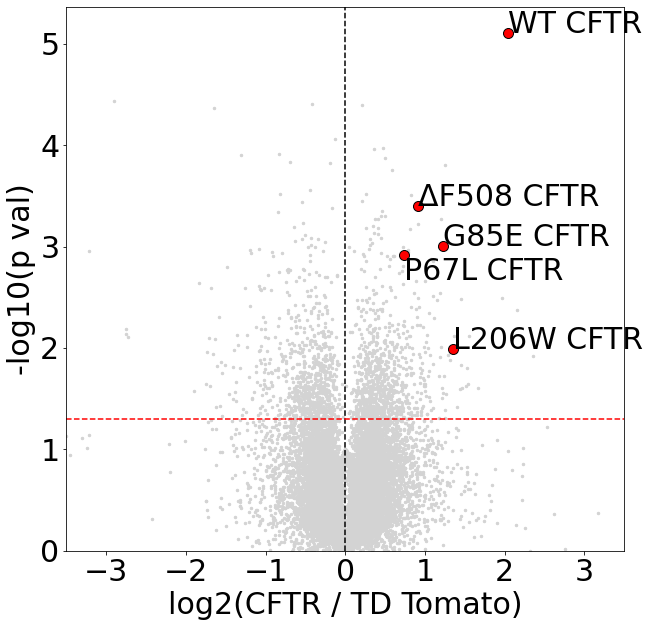

In [147]:
cutoff = -np.log10(0.05)
rng = 3.5
fontsize = 30
plt.figure(figsize=(10,10))

plt.scatter(x,  y,  color = 'lightgrey', s=6)
plt.scatter(x0, y0, color = 'lightgrey', s=6)
plt.scatter(x1, y1, color = 'lightgrey', s=6)
plt.scatter(x2, y2, color = 'lightgrey', s=6)
plt.scatter(x3, y3, color = 'lightgrey', s=6)
plt.scatter(x4, y4, color = 'lightgrey', s=6)
plt.scatter(x5, y5, color = 'lightgrey', s=6)
plt.scatter(x6, y6, color = 'lightgrey', s=6)
plt.scatter(x7, y7, color = 'lightgrey', s=6)
plt.scatter(x8, y8, color = 'lightgrey', s=6)

plt.vlines((0), 0, max(y)+0.25, ls='--' , color = 'k')
plt.hlines(cutoff, -rng, rng, ls='--' , color = 'red')
plt.xlim(-rng,rng)
plt.ylim(0,max(y)+0.25)

for i in x7.items(): 
    if y7[i[0]] >= cutoff and x7[i[0]] >0 and str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome:  
        #plt.scatter(x7[i[0]], y7[i[0]], color = 'coral',edgecolor='k',s = 50)
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x7[i[0]], y7[i[0]], color = 'r', edgecolor='k', s=100, zorder =1)
            plt.text(x7[i[0]],y7[i[0]], 'G85E CFTR', size=fontsize, color ='k', zorder =1)
   # elif y7[i[0]] >= cutoff and x7[i[0]] >0: 
    #    plt.scatter(x7[i[0]], y7[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
    #elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x7[i[0]] > np.std(x7):
     #   plt.scatter(x7[i[0]], y7[i[0]], color = 'lime',edgecolor='k',s =25)
'''  
for i in x8.items(): 
    if y8[i[0]] >= cutoff and x8[i[0]] >0 and str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome: 
        plt.scatter(x8[i[0]], y8[i[0]], color = 'coral',edgecolor='k',s = 50)
    elif y8[i[0]] >= cutoff and x8[i[0]] >0: 
        plt.scatter(x8[i[0]], y8[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x8[i[0]] > np.std(x8):
        plt.scatter(x8[i[0]], y8[i[0]], color = 'lime',edgecolor='k',s =25)
'''  
for i in x.items(): 
    if y[i[0]] >= cutoff and x[i[0]] >0 and str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome: 
        #plt.scatter(x[i[0]], y[i[0]], color = 'coral',edgecolor='k',s = 50)
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x[i[0]], y[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x[i[0]],y[i[0]], 'WT CFTR', size=fontsize, color ='k')
    #elif y[i[0]] >= cutoff and x[i[0]] >0: 
     #   plt.scatter(x[i[0]], y[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
    #elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x[i[0]] > np.std(x):
     #   plt.scatter(x[i[0]], y[i[0]], color = 'lime',edgecolor='k',s =25)
'''    
for i in x0.items(): 
    if y0[i[0]] >= cutoff and x0[i[0]] >0 and str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome: 
        plt.scatter(x0[i[0]], y0[i[0]], color = 'coral',edgecolor='k',s = 50)
    elif y0[i[0]] >= cutoff and x0[i[0]] >0: 
        plt.scatter(x0[i[0]], y0[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x0[i[0]] > np.std(x0):
        plt.scatter(x0[i[0]], y0[i[0]], color = 'lime',edgecolor='k',s =25)
'''   
for i in x1.items(): 
    if y1[i[0]] >= cutoff and x1[i[0]] >0 and str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome: 
        #plt.scatter(x1[i[0]], y1[i[0]], color = 'coral',edgecolor='k',s = 50)
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x1[i[0]], y1[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x1[i[0]],y1[i[0]], '\u0394F508 CFTR', size=fontsize, color ='k')
    #elif y1[i[0]] >= cutoff and x1[i[0]] >0: 
     #   plt.scatter(x1[i[0]], y1[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
    #elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x1[i[0]] > np.std(x1):
     #   plt.scatter(x1[i[0]], y1[i[0]], color = 'lime',edgecolor='k',s =25)
'''    
for i in x2.items(): 
    if y2[i[0]] >= cutoff and x2[i[0]] >0 and str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome: 
        plt.scatter(x2[i[0]], y2[i[0]], color = 'coral',edgecolor='k',s = 50)
    elif y2[i[0]] >= cutoff and x2[i[0]] >0: 
        plt.scatter(x2[i[0]], y2[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x2[i[0]] > np.std(x2):
        plt.scatter(x2[i[0]], y2[i[0]], color = 'lime',edgecolor='k',s =25)
'''     
for i in x3.items(): 
    if y3[i[0]] >= cutoff and x3[i[0]] >0 and str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome:  
        #plt.scatter(x3[i[0]], y3[i[0]], color = 'coral',edgecolor='k',s = 50)
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x3[i[0]], y3[i[0]], color = 'r', edgecolor='k', s=100, zorder =1)
            plt.text(x3[i[0]],y3[i[0]]-0.25, 'P67L CFTR', size=fontsize, color ='k', zorder =1)
    #elif y3[i[0]] >= cutoff and x3[i[0]] >0: 
     #   plt.scatter(x3[i[0]], y3[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
    #elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x3[i[0]] > np.std(x3):
     #   plt.scatter(x3[i[0]], y3[i[0]], color = 'lime',edgecolor='k',s =25)
''' 
for i in x4.items(): 
    if y4[i[0]] >= cutoff and x4[i[0]] >0 and str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome: 
        plt.scatter(x4[i[0]], y4[i[0]], color = 'coral',edgecolor='k',s = 50)
    elif y4[i[0]] >= cutoff and x4[i[0]] >0: 
        plt.scatter(x4[i[0]], y4[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x4[i[0]] > np.std(x4):
        plt.scatter(x4[i[0]], y4[i[0]], color = 'lime',edgecolor='k',s =25)
 '''         
        
for i in x5.items(): 
    if y5[i[0]] >= cutoff and x5[i[0]] >0 and str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome:  
        #plt.scatter(x5[i[0]], y5[i[0]], color = 'coral',edgecolor='k',s = 50)
        if data2.iloc[i[0]]['Gene Name'] == 'CFTR':
            plt.scatter(x5[i[0]], y5[i[0]], color = 'r', edgecolor='k', s=100)
            plt.text(x5[i[0]],y5[i[0]], 'L206W CFTR', size=fontsize, color ='k')
    #elif y5[i[0]] >= cutoff and x5[i[0]] >0: 
     #   plt.scatter(x5[i[0]], y5[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
    #elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x5[i[0]] > np.std(x5):
     #   plt.scatter(x5[i[0]], y5[i[0]], color = 'lime',edgecolor='k',s =25)
'''    
for i in x6.items(): 
    if y6[i[0]] >= cutoff and x6[i[0]] >0 and str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome: 
        plt.scatter(x6[i[0]], y6[i[0]], color = 'coral',edgecolor='k',s = 50)
    elif y6[i[0]] >= cutoff and x6[i[0]] >0: 
        plt.scatter(x6[i[0]], y6[i[0]], color = 'deepskyblue',edgecolor='k',s = 50)
    elif str(data2.iloc[i[0]]['Gene Name']) in Pankow_and_Hutt_core_interactome and x6[i[0]] > np.std(x6):
        plt.scatter(x6[i[0]], y6[i[0]], color = 'lime',edgecolor='k',s =25)
'''       


        
plt.xlabel('log2(CFTR / TD Tomato)', size=fontsize)
plt.ylabel('-log10(p val)', size=fontsize)
plt.xticks(size=fontsize)
plt.yticks(size=fontsize)
#plt.savefig('/Users/elimcdonald/Desktop/Volcano_plt1pnt5.png', format='png')


In [148]:
print('F508del + DMSO  = ' + str(len(F508del_DMSO_interactors)))
print('F508del + VX809 = ' + str(len(F508del_VX809_interactors)))
print('\n')
print('P67L + DMSO  = ' + str(len(P67L_DMSO_interactors)))
print('P67L + VX809 = ' + str(len(P67L_VX809_interactors)))
print('\n')
print('L206W + DMSO  = ' + str(len(L206W_DMSO_interactors)))
print('L206W+ VX809 = ' + str(len(L206W_VX809_interactors)))
print('\n')
print('G85E + DMSO  = ' + str(len(G85E_DMSO_interactors)))
print('G85E + VX809 = ' + str(len(G85E_VX809_interactors)))

F508del + DMSO  = 64
F508del + VX809 = 50


P67L + DMSO  = 86
P67L + VX809 = 104


L206W + DMSO  = 86
L206W+ VX809 = 66


G85E + DMSO  = 209
G85E + VX809 = 136


In [149]:
import scipy.stats as stats


In [154]:
data4 = data3.set_index('Gene Name')

In [172]:
data5 = pd.DataFrame()

In [155]:
CFTR_quant = [np.mean(data4.loc['CFTR'][mock]), 
              np.mean(data4.loc['CFTR'][WT_DMSO]), np.mean(data4.loc['CFTR'][WT_VX809]), 
              np.mean(data4.loc['CFTR'][P67L_DMSO]), np.mean(data4.loc['CFTR'][P67L_VX809]),
              np.mean(data4.loc['CFTR'][G85E_DMSO]), np.mean(data4.loc['CFTR'][G85E_VX809]),
              np.mean(data4.loc['CFTR'][L206W_DMSO]), np.mean(data4.loc['CFTR'][L206W_VX809]),
              np.mean(data4.loc['CFTR'][F508del_DMSO]), np.mean(data4.loc['CFTR'][F508del_VX809])]

CFTR_err = [stats.sem(data4.loc['CFTR'][mock]), 
            stats.sem(data4.loc['CFTR'][WT_DMSO]), 
            np.std(data4.loc['CFTR'][WT_DMSO])/np.sqrt(len(data4.loc['CFTR'][WT_DMSO]))
            np.std(data4.loc['CFTR'][WT_VX809])/np.sqrt(len(data4.loc['CFTR'][WT_VX809])), 
            stats.sem(data4.loc['CFTR'][P67L_DMSO]), 
            stats.sem(data4.loc['CFTR'][P67L_VX809]),
            stats.sem(data4.loc['CFTR'][G85E_DMSO]),
            stats.sem(data4.loc['CFTR'][G85E_VX809]),
            stats.sem(data4.loc['CFTR'][L206W_DMSO]),
            stats.sem(data4.loc['CFTR'][L206W_VX809]),
            stats.sem(data4.loc['CFTR'][F508del_DMSO]),
            stats.sem(data4.loc['CFTR'][F508del_VX809])]


CFTR_quant_norm = np.array(CFTR_quant)/np.mean(data4.loc['CFTR'][WT_DMSO])

In [199]:
data4.loc['CFTR'][G85E_VX809]

Run 5 G85E-VX809       13102.593798
Run 10 G85E-VX809       7146.990115
Run 11 G85E-VX809       1542.982925
Run 12 G85E-VX809       2666.487459
Run 12 G85E-VX809.1     7725.938113
Run 13 G85E-VX809       2871.143585
Run 13 G85E-VX809.1     3233.061686
Run 13 G85E-VX809.2     4004.032550
Name: CFTR, dtype: float64

In [200]:
[print(i) for i in list(data4.loc['CFTR'][G85E_VX809].values)]

13102.593797996053
7146.990115440115
1542.982925058973
2666.4874593098957
7725.938112612612
2871.1435851472474
3233.061685682739
4004.0325501952043


[None, None, None, None, None, None, None, None]

In [162]:
np.std(data4.loc['CFTR'][WT_DMSO])/np.sqrt(len(data4.loc['CFTR'][WT_DMSO]))

11742.533428715089

In [203]:
CFTR_quant_norm = [0.277485447, 1, 1.135707386, 0.497784846, 0.694093143, 0.443528202, 0.440923087, 0.594991105, 0.951578489, 0.54834836, 0.665263631]
CFTR_err_norm = [0.059090548, 0, 0.18254973, 0.060986982, 0.086215159, 0.087071498, 0.067750077, 0.155500904, 0.294701813, 0.067761054, 0.09034391]


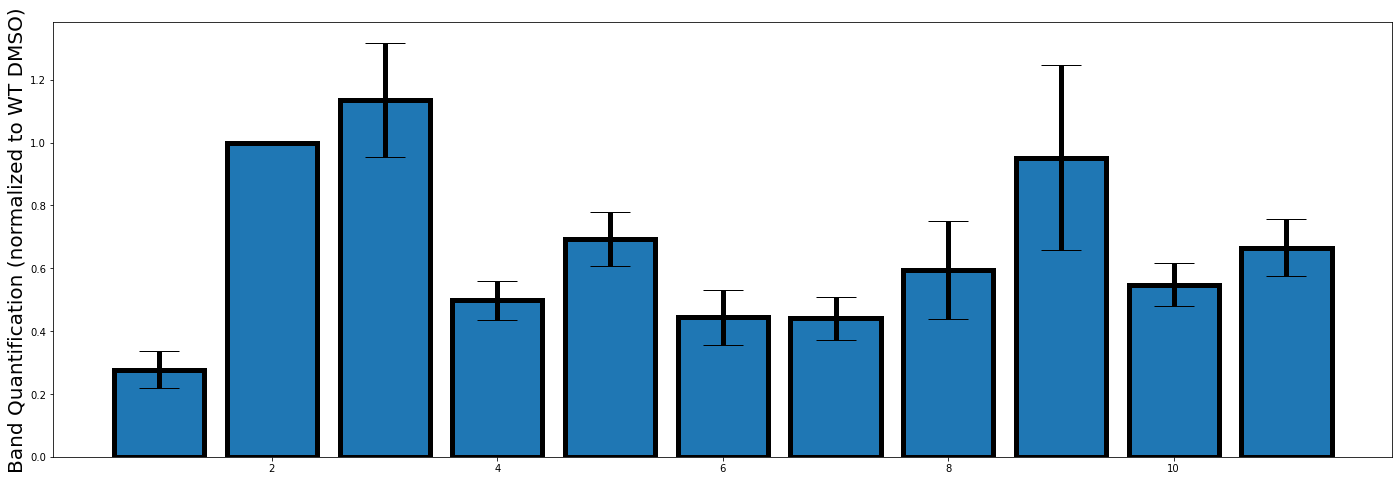

In [210]:
plt.figure(figsize=(24,8))
plt.bar([1,2,3,4,5,6,7,8,9,10,11], height=CFTR_quant_norm, edgecolor='k', lw=5) 
plt.errorbar([1,2,3,4,5,6,7,8,9,10,11], CFTR_quant_norm, yerr=CFTR_err_norm, ecolor='k', capsize=20, lw=5, ls='none')
plt.ylabel('Band Quantification (normalized to WT DMSO)', size=20)

plt.savefig('../Figures/WesternBlots-Figure1/TMT_CFTR_quant_2.svg', format='svg')

In [3]:
import matplotlib.pyplot as plt

In [1]:
CFTR_blot_quant = [0.011190325, 1, 0.751553492, 0.049130361, 0.432594699, 0.042418469, 0.038443716, 0.107729901, 0.624689517, 0.117941648, 0.189757744]




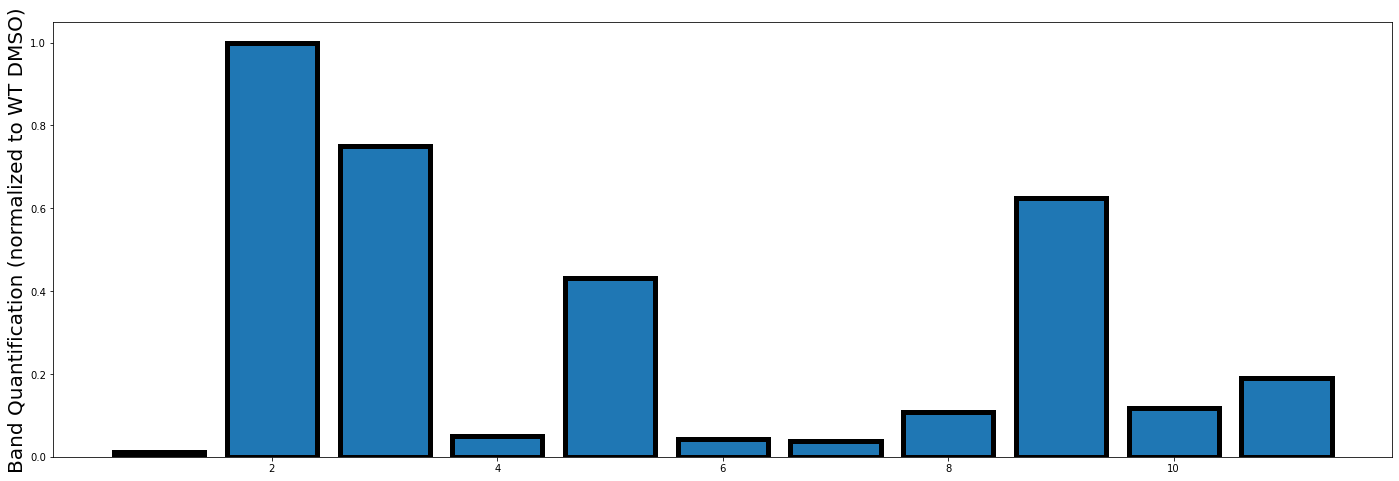

In [5]:
plt.figure(figsize=(24,8))
plt.bar([1,2,3,4,5,6,7,8,9,10,11], height=CFTR_blot_quant, edgecolor='k', lw=5) 

plt.ylabel('Band Quantification (normalized to WT DMSO)', size=20)

plt.savefig('../Figures/WesternBlots-Figure1/Blot_CFTR_quant_2.svg', format='svg')

# Heatmaps

In [146]:
import seaborn as sns

In [147]:
data4 = data3.set_index('Gene Name')

In [148]:
## noramlize to CFTR levels in each run 
WT_DMSO_CFTRnorm = np.log2(data3[WT_DMSO]) -np.log2(data4.loc['CFTR'][WT_DMSO], dtype=float)

WT_DMSO_mock = get_mock_runs(WT_DMSO_CFTRnorm, WT_DMSO_CFTRnorm,0)

WT_DMSO_over_WT_DMSO = pd.DataFrame(WT_DMSO_CFTRnorm.values - WT_DMSO_mock.values)
## filter out any proteins which were not identified in at least 3 runs 
WT_DMSO_over_WT_DMSO.index = data3.index

drop_rows = []

for i,val in WT_DMSO_over_WT_DMSO.iterrows():
    if val.isna().sum() >  len(WT_DMSO_over_WT_DMSO.columns)-2:
        drop_rows.append(i)
        
WT_DMSO_over_WT_DMSO = WT_DMSO_over_WT_DMSO.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(WT_DMSO_over_WT_DMSO)))


WT_DMSO_over_WT_DMSO_2plot = pd.DataFrame()
WT_DMSO_over_WT_DMSO_2plot['avg'] = WT_DMSO_over_WT_DMSO.mean(axis=1)
WT_DMSO_over_WT_DMSO_2plot['med'] = WT_DMSO_over_WT_DMSO.median(axis=1)
WT_DMSO_over_WT_DMSO_2plot['std'] = WT_DMSO_over_WT_DMSO.std(axis=1)

the number of interactors left = 2302


In [149]:
## noramlize to CFTR levels in each run 
WT_VX809_CFTRnorm = np.log2(data3[WT_VX809]) -np.log2(data4.loc['CFTR'][WT_VX809], dtype=float)

WT_VX809_mock = get_mock_runs(WT_VX809_CFTRnorm, WT_DMSO_CFTRnorm,0)

WT_VX809_over_WT_DMSO = pd.DataFrame(WT_VX809_CFTRnorm.values - WT_VX809_mock.values)

## filter out any proteins which were not identified in at least 3 runs 
WT_VX809_over_WT_DMSO.index = data3.index

drop_rows = []

for i,val in WT_VX809_over_WT_DMSO.iterrows():
    if val.isna().sum() >  len(WT_VX809_over_WT_DMSO.columns)-2:
        drop_rows.append(i)
        
WT_VX809_over_WT_DMSO = WT_VX809_over_WT_DMSO.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(WT_VX809_over_WT_DMSO)))


WT_VX809_over_WT_DMSO_2plot = pd.DataFrame()
WT_VX809_over_WT_DMSO_2plot['avg'] = WT_VX809_over_WT_DMSO.mean(axis=1)
WT_VX809_over_WT_DMSO_2plot['med'] = WT_VX809_over_WT_DMSO.median(axis=1)
WT_VX809_over_WT_DMSO_2plot['std'] = WT_VX809_over_WT_DMSO.std(axis=1)

the number of interactors left = 1665


In [150]:
## noramlize to CFTR levels in each run 
F508del_DMSO_CFTRnorm = np.log2(data3[F508del_DMSO]) -np.log2(data4.loc['CFTR'][F508del_DMSO], dtype=float)
F508del_DMSO_mock = get_mock_runs(F508del_DMSO_CFTRnorm, WT_DMSO_CFTRnorm,0)

F508del_DMSO_over_WT_DMSO = pd.DataFrame(F508del_DMSO_CFTRnorm.values - F508del_DMSO_mock.values)

## filter out any proteins which were not identified in at least 3 runs 
F508del_DMSO_over_WT_DMSO.index = data3.index

drop_rows = []

for i,val in F508del_DMSO_over_WT_DMSO.iterrows():
    if val.isna().sum() >  len(F508del_DMSO_over_WT_DMSO.columns)-2:
        drop_rows.append(i)
        
F508del_DMSO_over_WT_DMSO = F508del_DMSO_over_WT_DMSO.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(F508del_DMSO_over_WT_DMSO)))

F508del_DMSO_over_WT_DMSO_2plot = pd.DataFrame()
F508del_DMSO_over_WT_DMSO_2plot['avg'] = F508del_DMSO_over_WT_DMSO.mean(axis=1)
F508del_DMSO_over_WT_DMSO_2plot['med'] = F508del_DMSO_over_WT_DMSO.median(axis=1)
F508del_DMSO_over_WT_DMSO_2plot['std'] = F508del_DMSO_over_WT_DMSO.std(axis=1)

the number of interactors left = 1487


In [151]:
F508del_VX809_CFTRnorm = np.log2(data3[F508del_VX809]) -np.log2(data4.loc['CFTR'][F508del_VX809], dtype=float)
F508del_VX809_mock = get_mock_runs(F508del_VX809_CFTRnorm, WT_DMSO_CFTRnorm,0)

F508del_VX809_over_WT_DMSO = pd.DataFrame(F508del_VX809_CFTRnorm.values - F508del_VX809_mock.values)

## filter out any proteins which were not identified in at least 3 runs 
F508del_VX809_over_WT_DMSO_2plot = pd.DataFrame()
F508del_VX809_over_WT_DMSO_2plot['nans'] = F508del_VX809_over_WT_DMSO.isna().sum(axis=1)

drop_rows = []
for i,val in enumerate(F508del_VX809_over_WT_DMSO_2plot['nans']):
    if val > len(F508del_VX809_over_WT_DMSO.columns)-2:
        drop_rows.append(i)
        
F508del_VX809_over_WT_DMSO = F508del_VX809_over_WT_DMSO.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(F508del_VX809_over_WT_DMSO)))

F508del_VX809_over_WT_DMSO_2plot = pd.DataFrame()
F508del_VX809_over_WT_DMSO_2plot['avg'] = F508del_VX809_over_WT_DMSO.mean(axis=1)
F508del_VX809_over_WT_DMSO_2plot['med'] = F508del_VX809_over_WT_DMSO.median(axis=1)
F508del_VX809_over_WT_DMSO_2plot['std'] = F508del_VX809_over_WT_DMSO.std(axis=1)

the number of interactors left = 1486


In [152]:
## noramlize to CFTR levels in each run 
P67L_DMSO_CFTRnorm = np.log2(data3[P67L_DMSO]) -np.log2(data4.loc['CFTR'][P67L_DMSO], dtype=float)
P67L_DMSO_mock = get_mock_runs(P67L_DMSO_CFTRnorm, WT_DMSO_CFTRnorm,0)

P67L_DMSO_over_WT_DMSO = pd.DataFrame(P67L_DMSO_CFTRnorm.values - P67L_DMSO_mock.values)

## filter out any proteins which were not identified in at least 3 runs 
P67L_DMSO_over_WT_DMSO.index = data3.index

drop_rows = []

for i,val in P67L_DMSO_over_WT_DMSO.iterrows():
    if val.isna().sum() >  len(P67L_DMSO_over_WT_DMSO.columns)-2:
        drop_rows.append(i)
        
P67L_DMSO_over_WT_DMSO = P67L_DMSO_over_WT_DMSO.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(P67L_DMSO_over_WT_DMSO)))


P67L_DMSO_over_WT_DMSO_2plot = pd.DataFrame()
P67L_DMSO_over_WT_DMSO_2plot['avg'] = P67L_DMSO_over_WT_DMSO.mean(axis=1)
P67L_DMSO_over_WT_DMSO_2plot['med'] = P67L_DMSO_over_WT_DMSO.median(axis=1)
P67L_DMSO_over_WT_DMSO_2plot['std'] = P67L_DMSO_over_WT_DMSO.std(axis=1)

the number of interactors left = 1778


In [153]:
P67L_VX809_CFTRnorm = np.log2(data3[P67L_VX809]) -np.log2(data4.loc['CFTR'][P67L_VX809], dtype=float)
P67L_VX809_mock = get_mock_runs(P67L_VX809_CFTRnorm, WT_DMSO_CFTRnorm,0)

P67L_VX809_over_WT_DMSO = pd.DataFrame(P67L_VX809_CFTRnorm.values - P67L_VX809_mock.values)

## filter out any proteins which were not identified in at least 3 runs 
P67L_VX809_over_WT_DMSO.index = data3.index

drop_rows = []

for i,val in P67L_VX809_over_WT_DMSO.iterrows():
    if val.isna().sum() >  len(P67L_VX809_over_WT_DMSO.columns)-2:
        drop_rows.append(i)
        
P67L_VX809_over_WT_DMSO = P67L_VX809_over_WT_DMSO.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(P67L_VX809_over_WT_DMSO)))


P67L_VX809_over_WT_DMSO_2plot = pd.DataFrame()
P67L_VX809_over_WT_DMSO_2plot['avg'] = P67L_VX809_over_WT_DMSO.mean(axis=1)
P67L_VX809_over_WT_DMSO_2plot['med'] = P67L_VX809_over_WT_DMSO.median(axis=1)
P67L_VX809_over_WT_DMSO_2plot['std'] = P67L_VX809_over_WT_DMSO.std(axis=1)

the number of interactors left = 1778


In [154]:
## noramlize to CFTR levels in each run 
L206W_DMSO_CFTRnorm = np.log2(data3[L206W_DMSO]) -np.log2(data4.loc['CFTR'][L206W_DMSO], dtype=float)
L206W_DMSO_mock = get_mock_runs(L206W_DMSO_CFTRnorm, WT_DMSO_CFTRnorm,0)

L206W_DMSO_over_WT_DMSO = pd.DataFrame(L206W_DMSO_CFTRnorm.values - L206W_DMSO_mock.values)

# filter out any proteins which were not identified in at least 3 runs 
L206W_DMSO_over_WT_DMSO.index = data3.index

drop_rows = []

for i,val in L206W_DMSO_over_WT_DMSO.iterrows():
    if val.isna().sum() >  len(L206W_DMSO_over_WT_DMSO.columns)-2:
        drop_rows.append(i)
        
L206W_DMSO_over_WT_DMSO = L206W_DMSO_over_WT_DMSO.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(L206W_DMSO_over_WT_DMSO)))

L206W_DMSO_over_WT_DMSO_2plot = pd.DataFrame()
L206W_DMSO_over_WT_DMSO_2plot['avg'] = L206W_DMSO_over_WT_DMSO.mean(axis=1)
L206W_DMSO_over_WT_DMSO_2plot['med'] = L206W_DMSO_over_WT_DMSO.median(axis=1)
L206W_DMSO_over_WT_DMSO_2plot['std'] = L206W_DMSO_over_WT_DMSO.std(axis=1)

the number of interactors left = 2353


In [155]:
L206W_VX809_CFTRnorm = np.log2(data3[L206W_VX809]) -np.log2(data4.loc['CFTR'][L206W_VX809], dtype=float)
L206W_VX809_mock = get_mock_runs(L206W_VX809_CFTRnorm, WT_DMSO_CFTRnorm,0)

L206W_VX809_over_WT_DMSO = pd.DataFrame(L206W_VX809_CFTRnorm.values - L206W_VX809_mock.values)

## filter out any proteins which were not identified in at least 3 runs 
L206W_VX809_over_WT_DMSO.index = data3.index

drop_rows = []

for i,val in L206W_VX809_over_WT_DMSO.iterrows():
    if val.isna().sum() >  len(L206W_VX809_over_WT_DMSO.columns)-2:
        drop_rows.append(i)
        
L206W_VX809_over_WT_DMSO = L206W_VX809_over_WT_DMSO.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(L206W_VX809_over_WT_DMSO)))



L206W_VX809_over_WT_DMSO_2plot = pd.DataFrame()
L206W_VX809_over_WT_DMSO_2plot['avg'] = L206W_VX809_over_WT_DMSO.mean(axis=1)
L206W_VX809_over_WT_DMSO_2plot['med'] = L206W_VX809_over_WT_DMSO.median(axis=1)
L206W_VX809_over_WT_DMSO_2plot['std'] = L206W_VX809_over_WT_DMSO.std(axis=1)

the number of interactors left = 2357


In [156]:
## noramlize to CFTR levels in each run 
G85E_DMSO_CFTRnorm = np.log2(data3[G85E_DMSO]) -np.log2(data4.loc['CFTR'][G85E_DMSO], dtype=float)
G85E_DMSO_mock = get_mock_runs(G85E_DMSO_CFTRnorm, WT_DMSO_CFTRnorm,0)

G85E_DMSO_over_WT_DMSO = pd.DataFrame(G85E_DMSO_CFTRnorm.values - G85E_DMSO_mock.values)

# filter out any proteins which were not identified in at least 3 runs 
G85E_DMSO_over_WT_DMSO.index = data3.index

drop_rows = []

for i,val in G85E_DMSO_over_WT_DMSO.iterrows():
    if val.isna().sum() >  len(G85E_DMSO_over_WT_DMSO.columns)-2:
        drop_rows.append(i)
        
G85E_DMSO_over_WT_DMSO = G85E_DMSO_over_WT_DMSO.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(G85E_DMSO_over_WT_DMSO)))

G85E_DMSO_over_WT_DMSO_2plot = pd.DataFrame()
G85E_DMSO_over_WT_DMSO_2plot['avg'] = G85E_DMSO_over_WT_DMSO.mean(axis=1)
G85E_DMSO_over_WT_DMSO_2plot['med'] = G85E_DMSO_over_WT_DMSO.median(axis=1)
G85E_DMSO_over_WT_DMSO_2plot['std'] = G85E_DMSO_over_WT_DMSO.std(axis=1)

the number of interactors left = 2624


In [157]:
G85E_VX809_CFTRnorm = np.log2(data3[G85E_VX809]) -np.log2(data4.loc['CFTR'][G85E_VX809], dtype=float)
G85E_VX809_mock = get_mock_runs(G85E_VX809_CFTRnorm, WT_DMSO_CFTRnorm,0)

G85E_VX809_over_WT_DMSO = pd.DataFrame(G85E_VX809_CFTRnorm.values - G85E_VX809_mock.values)


# filter out any proteins which were not identified in at least 3 runs 
G85E_VX809_over_WT_DMSO.index = data3.index

drop_rows = []

for i,val in G85E_VX809_over_WT_DMSO.iterrows():
    if val.isna().sum() >  len(G85E_VX809_over_WT_DMSO.columns)-2:
        drop_rows.append(i)
        
G85E_VX809_over_WT_DMSO = G85E_VX809_over_WT_DMSO.drop(axis=0, index=drop_rows)
print('the number of interactors left = ' +str(len(G85E_VX809_over_WT_DMSO)))

G85E_VX809_over_WT_DMSO_2plot = pd.DataFrame()
G85E_VX809_over_WT_DMSO_2plot['avg'] = G85E_VX809_over_WT_DMSO.mean(axis=1)
G85E_VX809_over_WT_DMSO_2plot['med'] = G85E_VX809_over_WT_DMSO.median(axis=1)
G85E_VX809_over_WT_DMSO_2plot['std'] = G85E_VX809_over_WT_DMSO.std(axis=1)

the number of interactors left = 2624


In [158]:
prioritized_list = np.concatenate(  [WT_DMSO_interactors, WT_VX809_interactors,
                                    F508del_DMSO_interactors, F508del_VX809_interactors,
                                    L206W_DMSO_interactors, L206W_VX809_interactors,
                                    G85E_DMSO_interactors, G85E_VX809_interactors,
                                    upregulted_former_interactors])

In [146]:
len(set(upregulted_former_interactors))

234

In [147]:
prioritized_list = set(prioritized_list)

In [148]:
len(prioritized_list)

672

In [699]:
to_heatmap =pd.DataFrame()
to_heatmap['prot'] = data3['Gene Name']
to_heatmap['WT DMSO'] = WT_DMSO_over_WT_DMSO_2plot['avg']
to_heatmap['WT VX809'] = WT_VX809_over_WT_DMSO_2plot['avg']
to_heatmap['F508del DMSO'] = F508del_DMSO_over_WT_DMSO_2plot['avg']
to_heatmap['F508del VX809'] = F508del_VX809_over_WT_DMSO_2plot['avg']
to_heatmap['P67L DMSO'] = P67L_DMSO_over_WT_DMSO_2plot['avg']
to_heatmap['P67L VX809'] = P67L_VX809_over_WT_DMSO_2plot['avg']
to_heatmap['L206W DMSO'] = L206W_DMSO_over_WT_DMSO_2plot['avg']
to_heatmap['L206W VX809'] = L206W_VX809_over_WT_DMSO_2plot['avg']
to_heatmap['G85E DMSO'] = G85E_DMSO_over_WT_DMSO_2plot['avg']
to_heatmap['G85E VX809'] = G85E_VX809_over_WT_DMSO_2plot['avg']

to_heatmap['WT DMSO std'] = WT_DMSO_over_WT_DMSO_2plot['std']
to_heatmap['WT VX809 std'] = WT_VX809_over_WT_DMSO_2plot['std']
to_heatmap['F508del DMSO std'] = F508del_DMSO_over_WT_DMSO_2plot['std']
to_heatmap['F508del VX809 std'] = F508del_VX809_over_WT_DMSO_2plot['std']
to_heatmap['P67L DMSO std'] = P67L_DMSO_over_WT_DMSO_2plot['std']
to_heatmap['P67L VX809 std'] = P67L_VX809_over_WT_DMSO_2plot['std']
to_heatmap['L206W DMSO std'] = L206W_DMSO_over_WT_DMSO_2plot['std']
to_heatmap['L206W VX809 std'] = L206W_VX809_over_WT_DMSO_2plot['std']
to_heatmap['G85E DMSO std'] = G85E_DMSO_over_WT_DMSO_2plot['std']
to_heatmap['G85E VX809 std'] = G85E_VX809_over_WT_DMSO_2plot['std']


In [700]:
to_heatmap

prot  WT DMSO  WT VX809  \
0                                                 HSPA2      0.0 -0.413652   
1                                                   AGL      NaN       NaN   
2                                                   AGK      0.0 -0.173233   
3                                                 HSPA6      0.0       NaN   
4                                                 HSPA5      0.0 -0.299733   
5                                                 HSPA4      0.0  0.054082   
6                                                 HSPA9      0.0 -0.499003   
7                                                 HSPA8      0.0 -0.170433   
8                                                 SSFA2      NaN       NaN   
9                                                LAPTM5      NaN       NaN   
10                                                MZT2B      0.0 -0.186244   
11                                               PDCD10      0.0 -0.389368   
12                                                 IGKC      0.0  0.668731   
13                                                 IGKC      0.0       NaN   
14                                               ATPIF1      0.0  0.127615   
15                                                 ASS1      0.0       NaN   
16                                               CHMP1A      NaN       NaN   
17                                                NCBP1      0.0  0.049392   
18                                                MYPOP      0.0 -0.068756   
19                                                LARP1      0.0 -0.165017   
20                                                ATRIP      NaN       NaN   
21                                               GPR180      0.0 -0.167198   
22                                               RAD51C      NaN       NaN   
23                                                PPP4C      NaN       NaN   
24                                                 PRNP      NaN       NaN   
25                                               ZNF706      0.0  0.321477   
26                                          SRPR; SRPRA      0.0  0.038180   
27                                               RNF114      NaN       NaN   
28                                                 CRBN      0.0       NaN   
29                                               SPTLC2      NaN       NaN   
30                                               ZC3H14      NaN       NaN   
31                                               SPTLC1      0.0 -0.269054   
32                                               NACAP1      NaN       NaN   
33                                               ZC3H18      0.0  0.451451   
34                                                ABCD3      0.0 -0.081084   
35                                                 DHX9      0.0 -0.223352   
36                                                DIMT1      NaN       NaN   
37                                                OSGEP      0.0 -0.302784   
38                                                TCOF1      0.0  0.056155   
39                                                NUP98      0.0 -0.167035   
40                                                PTOV1      0.0 -0.541020   
41                                                NUP93      0.0 -0.480938   
42                                              PPP2R2C      0.0  0.473955   
43                                                CAMKV      NaN       NaN   
44                                        SMCR7L; MIEF1      NaN       NaN   
45                                               GOLIM4      NaN       NaN   
46                                         ACN9; SDHAF3      0.0  0.256247   
47                                                 OPA1      0.0 -0.454076   
48                                                 RHEB      0.0 -0.313519   
49                                              TRAPPC8      NaN       NaN   
50                                                VPS45      NaN       Na

In [553]:
'''
pathways = pd.read_excel('./heatmap_pathways5.xlsx')
new_prots = []
for i in prioritized_list:
    if i not in pathways['prot'].values:
        new_prots.append(i)
print(len(new_prots))
for i in new_prots:
    print(i)'''


"\npathways = pd.read_excel('./heatmap_pathways5.xlsx')\nnew_prots = []\nfor i in prioritized_list:\n    if i not in pathways['prot'].values:\n        new_prots.append(i)\nprint(len(new_prots))\nfor i in new_prots:\n    print(i)"

In [554]:
'''add_list = []
for i in new_prots:
    if i not in Pankow_CFTR_core['Official Gene symbol'].values:
        add_list.append(i)
        
len(add_list)'''

"add_list = []\nfor i in new_prots:\n    if i not in Pankow_CFTR_core['Official Gene symbol'].values:\n        add_list.append(i)\n        \nlen(add_list)"

In [566]:
not_in_list_ind = []
for i, val in enumerate(data3['Gene Name']):
    if val not in prioritized_list:
        not_in_list_ind.append(i)

In [567]:
to_heatmap = to_heatmap.drop(axis=0, index=not_in_list_ind)

In [701]:
to_heatmap = to_heatmap.set_index('prot')

In [703]:
to_heatmap.loc['CFTR']

WT DMSO              0.0
WT VX809             0.0
F508del DMSO         0.0
F508del VX809        0.0
P67L DMSO            0.0
P67L VX809           0.0
L206W DMSO           0.0
L206W VX809          0.0
G85E DMSO            0.0
G85E VX809           0.0
WT DMSO std          0.0
WT VX809 std         0.0
F508del DMSO std     0.0
F508del VX809 std    0.0
P67L DMSO std        0.0
P67L VX809 std       0.0
L206W DMSO std       0.0
L206W VX809 std      0.0
G85E DMSO std        0.0
G85E VX809 std       0.0
Name: CFTR, dtype: float64

In [570]:
annotated_pathways = pd.read_excel('./heatmap_pathways6.xlsx')
annotated_pathways = annotated_pathways.set_index('prot')

In [571]:
paths = []
for i in to_heatmap.index:
    paths.append(annotated_pathways.loc[i]['pathway'])
   
to_heatmap['pathway'] = np.array(paths)

In [572]:
to_heatmap.sort_values('pathway',inplace=True, ascending=True)

In [573]:
drop_rows = []
for i,val in to_heatmap.iterrows():
    if val.isna().sum() >  0:
        drop_rows.append(i)
        
to_heatmap = to_heatmap.drop(axis=0, index=drop_rows)
        

In [188]:
paths_of_interest = ['Translation', 'Endocytosis', 'Membrane Organization', 'Degradation', 'Proteasomal', 'Folding',
                     'Trafficking', 'Translocation', 'Translation','Autophagy']
prot_paths = []
for i in to_heatmap['pathway'].items():
    if i[1] in paths_of_interest:
        prot_paths.append(i[0])
        
to_heatmap_paths = to_heatmap.loc[prot_paths]

In [189]:
#to_heatmap_paths.to_excel('../Supplemental_Materials/Heatmap_Quantifications.xlsx')

In [240]:
to_heatmap_paths = to_heatmap

In [242]:
len(to_heatmap_paths.index)

672

In [596]:
to_heatmap_ordered = to_heatmap_paths.drop('pathway', axis=1)

In [597]:
to_heatmap_toplot=to_heatmap_ordered#.drop(['F508del DMSO', 'F508del VX809', 'P67L DMSO', 'P67L VX809', 'L206W DMSO', 'L206W VX809', 'G85E DMSO', 'G85E VX809'], axis=1)


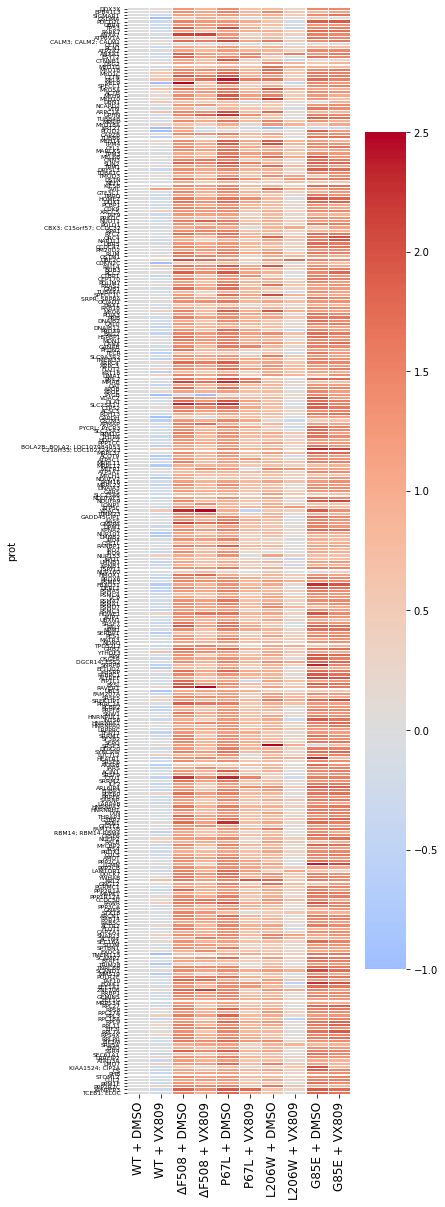

In [598]:
#diverging_colors = sns.color_palette("viridis", 10)
sns.diverging_palette(10, 10, as_cmap=True)

fig = plt.figure(figsize=(5,20))
ax=sns.heatmap(to_heatmap_toplot , vmin=-1, vmax=2.5,xticklabels=1,center=0, yticklabels=1, cbar=True,linewidths=.05, annot=False, cmap='coolwarm')
#ax.set_xticklabels(labels= ['WT + DMSO', '\u0394F508 + DMSO','\u0394F508 + VX809'],rotation=90, fontsize=12)
ax.set_xticklabels(labels= ['WT + DMSO', 'WT + VX809','\u0394F508 + DMSO','\u0394F508 + VX809', 'P67L + DMSO','P67L + VX809','L206W + DMSO', 'L206W + VX809', 'G85E + DMSO', 'G85E + VX809'],rotation=90, fontsize=12)
#ax.set_xticklabels(labels= ['WT + DMSO', 'WT + VX-809', '\u0394F508 DMSO','\u0394F508 VX809', 'P67L + DMSO','P67L + VX809'], rotation=90, fontsize=20)

ax.set_yticklabels(labels=to_heatmap_toplot.index, fontsize=6)

plt.savefig('../Figures/heatmap_all_paths_supp_fig.svg', fmt='svg')
plt.show()

In [243]:
Supp_DS_2 = to_heatmap_paths

In [244]:
Supp_DS_2_new= Supp_DS_2.drop(['WT DMSO', 'WT VX809', 
                'F508del DMSO', 'F508del VX809', 
                'P67L DMSO', 'P67L VX809', 
                'L206W DMSO', 'L206W VX809', 
                'G85E DMSO', 'G85E VX809', 
               ], axis=1)

In [245]:
Supp_DS_2_new

pathway
prot                                        
DDX3X                              Apoptosis
FAM162A                            Apoptosis
EPB41L3                            Apoptosis
MFGE8                              Apoptosis
SIGMAR1                            Apoptosis
...                                      ...
PPP2R2C      post translational modification
CHEK1        post translational modification
XPNPEP3      post translational modification
TCEB1; ELOC  post translational modification
C6orf47                      uncharacterized

[672 rows x 1 columns]

In [246]:
accessions = pd.read_excel('../Supplemental_Materials/Supplemental_Data_Set_1.xlsx', sheet_name='All Runs')
accessions2 = accessions[['Gene Name', 'Accesion Number']]

In [247]:
Supp_DS_2_new['Accession'] = np.zeros(len(Supp_DS_2_new.index))
for i,val in enumerate(accessions2['Gene Name']):
    #print(val)
    for j in Supp_DS_2_new.index:
        if j == val:
            #print(j)
            Supp_DS_2_new['Accession'].loc[j] =  accessions2['Accesion Number'][i]



/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [248]:
Supp_DS_2_new.to_excel('../Supplemental_Materials/Supplemental_Data_Set_2.xlsx')

In [250]:
len(Supp_DS_2_new

672

# Correlation Plots

In [160]:
prioritized_list = set(prioritized_list)

In [597]:
cp_df = pd.DataFrame()

cp_df['WT DMSO'] = WT_DMSO_over_TD_2plot['avg']
cp_df['WT DMSO err'] = WT_DMSO_over_TD_2plot['std']/np.sqrt(len(WT_DMSO_over_TD.columns))

cp_df['WT VX809'] = WT_VX809_over_TD_2plot['avg']
cp_df['WT VX809 err'] = WT_VX809_over_TD_2plot['std']/np.sqrt(len(WT_VX809_over_TD.columns))

cp_df['F508del DMSO'] = F508del_DMSO_over_TD_2plot['avg']
cp_df['F508del DMSO err'] = F508del_DMSO_over_TD_2plot['std']/np.sqrt(len(F508del_DMSO_over_TD.columns))

cp_df['F508del VX809'] = F508del_VX809_over_TD_2plot['avg']
cp_df['F508del VX809 err'] = F508del_VX809_over_TD_2plot['std']/np.sqrt(len(F508del_VX809_over_TD.columns))

cp_df['P67L DMSO'] = P67L_DMSO_over_TD_2plot['avg']
cp_df['P67L DMSO err'] = P67L_DMSO_over_TD_2plot['std']/np.sqrt(len(P67L_DMSO_over_TD.columns))

cp_df['P67L VX809'] = P67L_VX809_over_TD_2plot['avg']
cp_df['P67L VX809 err'] = P67L_VX809_over_TD_2plot['std']/np.sqrt(len(P67L_VX809_over_TD.columns))

cp_df['L206W DMSO'] = L206W_DMSO_over_TD_2plot['avg']
cp_df['L206W DMSO err'] = L206W_DMSO_over_TD_2plot['std']/np.sqrt(len(L206W_DMSO_over_TD.columns))

cp_df['L206W VX809'] = L206W_VX809_over_TD_2plot['avg']
cp_df['L206W VX809 err'] = L206W_VX809_over_TD_2plot['std']/np.sqrt(len(L206W_VX809_over_TD.columns))

cp_df['G85E DMSO'] = G85E_DMSO_over_TD_2plot['avg']
cp_df['G85E DMSO err'] = G85E_DMSO_over_TD_2plot['std']/np.sqrt(len(G85E_DMSO_over_TD.columns))

cp_df['G85E VX809'] = G85E_VX809_over_TD_2plot['avg']
cp_df['G85E VX809 err'] = G85E_VX809_over_TD_2plot['std']/np.sqrt(len(G85E_VX809_over_TD.columns))



In [574]:
cp_df = pd.DataFrame()

cp_df['WT DMSO'] = WT_DMSO_over_WT_DMSO_2plot['avg']
cp_df['WT DMSO err'] = WT_DMSO_over_WT_DMSO_2plot['std']/np.sqrt(len(WT_DMSO_over_TD.columns))

cp_df['WT VX809'] = WT_VX809_over_WT_DMSO_2plot['avg']
cp_df['WT VX809 err'] = WT_VX809_over_WT_DMSO_2plot['std']/np.sqrt(len(WT_VX809_over_TD.columns))

cp_df['F508del DMSO'] = F508del_DMSO_over_WT_DMSO_2plot['avg']
cp_df['F508del DMSO err'] = F508del_DMSO_over_WT_DMSO_2plot['std']/np.sqrt(len(F508del_DMSO_over_TD.columns))

cp_df['F508del VX809'] = F508del_VX809_over_WT_DMSO_2plot['avg']
cp_df['F508del VX809 err'] = F508del_VX809_over_WT_DMSO_2plot['std']/np.sqrt(len(F508del_VX809_over_TD.columns))

cp_df['P67L DMSO'] = P67L_DMSO_over_WT_DMSO_2plot['avg']
cp_df['P67L DMSO err'] = P67L_DMSO_over_WT_DMSO_2plot['std']/np.sqrt(len(P67L_DMSO_over_TD.columns))

cp_df['P67L VX809'] = P67L_VX809_over_WT_DMSO_2plot['avg']
cp_df['P67L VX809 err'] = P67L_VX809_over_WT_DMSO_2plot['std']/np.sqrt(len(P67L_VX809_over_TD.columns))

cp_df['L206W DMSO'] = L206W_DMSO_over_WT_DMSO_2plot['avg']
cp_df['L206W DMSO err'] = L206W_DMSO_over_WT_DMSO_2plot['std']/np.sqrt(len(L206W_DMSO_over_TD.columns))

cp_df['L206W VX809'] = L206W_VX809_over_WT_DMSO_2plot['avg']
cp_df['L206W VX809 err'] = L206W_VX809_over_WT_DMSO_2plot['std']/np.sqrt(len(L206W_VX809_over_TD.columns))

cp_df['G85E DMSO'] = G85E_DMSO_over_WT_DMSO_2plot['avg']
cp_df['G85E DMSO err'] = G85E_DMSO_over_WT_DMSO_2plot['std']/np.sqrt(len(G85E_DMSO_over_TD.columns))

cp_df['G85E VX809'] = G85E_VX809_over_WT_DMSO_2plot['avg']
cp_df['G85E VX809 err'] = G85E_VX809_over_WT_DMSO_2plot['std']/np.sqrt(len(G85E_VX809_over_TD.columns))



In [158]:
len(F508del_DMSO_over_TD.columns)

11

In [160]:
cp_df['protein'] = data2['Gene Name']

In [161]:

not_in_list_ind = []
for i in cp_df['protein'].items():
    if i[1] not in prioritized_list:
        not_in_list_ind.append(i[0])
        
cp_df = cp_df.drop(axis=0, index=not_in_list_ind)

In [178]:
from sklearn.neighbors import NearestNeighbors
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets


In [162]:
cp_df.to_excel('../../TMT_ML/WT_normalized_prot_interactions.xlsx')

In [153]:
cp_df = cp_df.set_index('protein')

In [204]:
annotated_pathways = pd.read_excel('./heatmap_pathways6.xlsx')
annotated_pathways = annotated_pathways.set_index('prot')

paths = []
for i in cp_df.index:
    paths.append(annotated_pathways.loc[i]['pathway'])
   
cp_df['pathway'] = np.array(paths)

In [260]:
paths_of_interest = ['Translation', 'Proteasomal', 'Folding',
                     'Trafficking','Autophagy', 'Endocytosis']
prot_paths = []
for i in cp_df['pathway'].items():
    if i[1] in paths_of_interest:
        prot_paths.append(i[0])
        
cp_paths = cp_df.loc[prot_paths]

In [261]:
p67l = []
for i in cp_paths.index:
    p67l.append([cp_paths.loc[i]['P67L DMSO'],cp_paths.loc[i]['P67L VX809']])
    
p67l = np.array(p67l)
p67l = np.nan_to_num(p67l, 0)

Automatically created module for IPython interactive environment


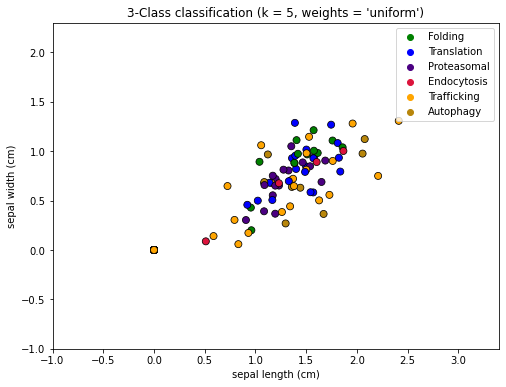

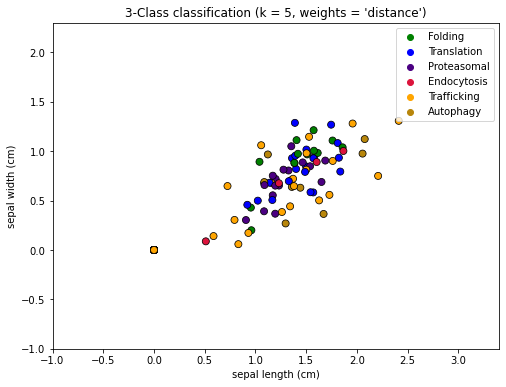

In [266]:
print(__doc__)

n_neighbors = 5

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = p67l
y = cp_paths['encode']

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['palegreen', 'skyblue', 'violet', 'lightcoral', 'lightpink', 'yellow'])
cmap_bold = ['green', 'blue', 'indigo', 'crimson', 'orange', 'darkgoldenrod']

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    #plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=np.array(cp_paths['pathway']),
                    palette=cmap_bold, alpha=1.0, edgecolor="black", s=50)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

plt.show()

In [205]:
len(cp_df[x])

2302

0.11255568290148321
0.35382983165327697


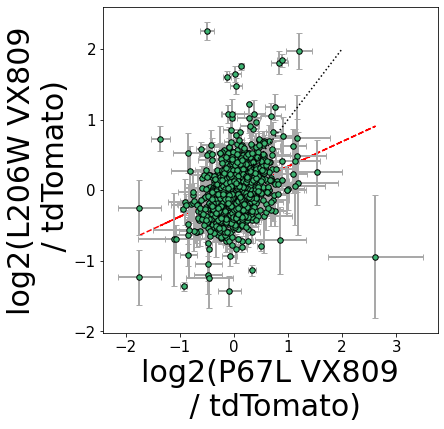

In [600]:
x = 'P67L VX809'
y = 'L206W VX809'
fontsize =30
idx = np.isfinite(cp_df[x]) & np.isfinite(cp_df[y])
m,b = np.polyfit(cp_df[x][idx], cp_df[y][idx], 1)


plt.figure(figsize=(6,6))
plt.plot([0,1,2], [0,1,2], ls=':', color='k')
plt.scatter(cp_df[x],cp_df[y] , color='mediumseagreen', edgecolor='k', s=30, zorder=1)
plt.errorbar(cp_df[x],cp_df[y], xerr=cp_df[x + ' err'], yerr = cp_df[x + ' err'],
             ls='none', ecolor='darkgrey', elinewidth=2, capsize=3, zorder=0 )
plt.plot(cp_df[x], m*cp_df[x] + b, color='r', ls='--', zorder=-1)

r2 = cp_df[[x, y]].corr('pearson').values[0,1]**2
plt.xlabel('log2('+ x + '\n / tdTomato)', size=fontsize)
plt.ylabel('log2('+ y + '\n / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-15)
plt.yticks(size=fontsize-15)
#plt.xlim(0,2)
#plt.ylim(0,2)

#plt.text(np.amax(x), np.amax(y),'r^2 = '+ str(r2), )

print(r2)
print(m)

In [ ]:
x = 'F508del DMSO'
y = 'F508del VX809'
fontsize =30
idx = np.isfinite(cp_df[y]) & np.isfinite(cp_df[y])
m,b = np.polyfit(cp_df[x][idx], cp_df[y][idx], 1)


plt.figure(figsize=(6,6))
plt.plot([0,1,2], [0,1,2], ls=':', color='k')
plt.scatter(cp_df[x],cp_df[y] , color='dodgerblue', edgecolor='k', s=20, zorder=1)
#plt.errorbar(cp_df[x],cp_df[y], xerr=cp_df[x + ' err'], yerr = cp_df[x + ' err'],
 #            ls='none', ecolor='darkgrey', elinewidth=2, capsize=3, zorder=0 )
plt.plot(cp_df[x], m*cp_df[x] + b, color='r', ls='--', zorder=-1)

r2 = cp_df[[x, y]].corr('pearson').values[0,1]**2
plt.xlabel('log2('+ x + '\n / tdTomato)', size=fontsize)
plt.ylabel('log2('+ y + '\n / tdTomato)', size=fontsize)
plt.xticks(size=fontsize-15)
plt.yticks(size=fontsize-15)
plt.xlim(0,2)
plt.ylim(0,2)

#plt.text(np.amax(x), np.amax(y),'r^2 = '+ str(r2), )
#plt.savefig('../Figures/correlation_plots/P67L_F508del_DMSO_corr.svg', format='svg')
print(r2)

# Violin plots

In [576]:
to_heatmap_paths = to_heatmap
to_heatmap_paths = to_heatmap_paths.drop('pathway', axis = 1)
to_heatmap_paths = to_heatmap_paths.sub(to_heatmap_paths['WT DMSO'], axis=0)
to_heatmap_paths['pathway'] = to_heatmap['pathway']

In [578]:
deg_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Degradation']

In [579]:
prot_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Proteasomal']

In [580]:
cyto_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Cytoskeleton']

In [581]:
ion_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Ion Transport/ Transporter']

In [582]:
auto_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Autophagy']

In [583]:
endo_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Endocytosis']

In [584]:
fold_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Folding']

In [585]:
traff_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Trafficking']

In [586]:
MO_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Membrane Organization']

In [587]:
transla_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Translation']

In [588]:
transloc_df = to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Translocation']

/Users/elimcdonald/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


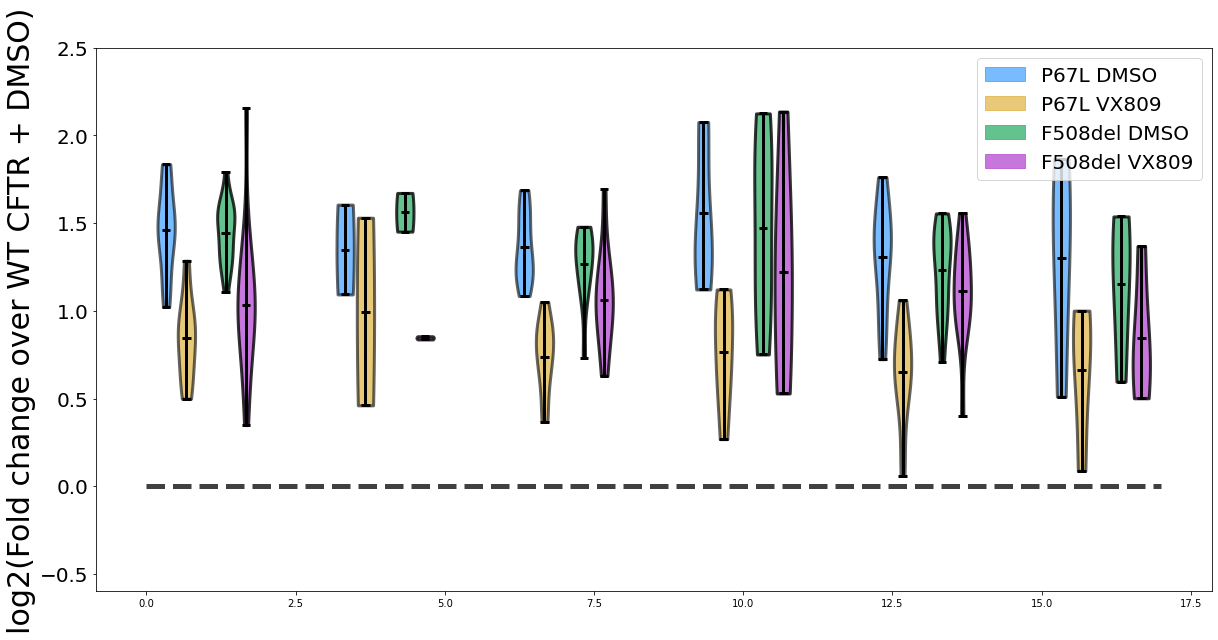

In [239]:
plt.figure(figsize=(20,10))
x0 = 'P67L DMSO'
x1 = 'P67L VX809'
x2 = 'F508del DMSO'
x3 = 'F508del VX809'
plt.hlines(0,0,17, ls='--', lw=5, color='k', alpha=0.75)

#paths = [transla_df, transloc_df, fold_df, prot_df, auto_df, endo_df, traff_df, MO_df,deg_df, cyto_df, ion_df]
paths = [ transla_df, fold_df, prot_df, auto_df, traff_df, endo_df,]
plt0 = [i[x0] for i in paths]
plt1 = [i[x1] for i in paths]
plt2 = [i[x2] for i in paths]
plt3 = [i[x3] for i in paths]

violin_parts0 = plt.violinplot(plt0,np.array([i*3 for i in np.arange(0,len(plt1))]) + 0.33, widths =.29, showmeans=1)

violin_parts1 = plt.violinplot(plt1,np.array([i*3 for i in np.arange(0,len(plt1))]) + 0.67, widths =.29, showmeans=1)
                       
violin_parts2 = plt.violinplot(plt2,np.array([i*3 for i in np.arange(0,len(plt1))]) + 1.33, widths =.29, showmeans=1)

violin_parts3 = plt.violinplot(plt3,np.array([i*3 for i in np.arange(0,len(plt1))]) + 1.67, widths =.29, showmeans=1)

plt.setp(violin_parts0['cmaxes'], color='k', linewidth =3)
plt.setp(violin_parts0['cmeans'], color='k', linewidth =3)
plt.setp(violin_parts0['cmins'], color='k', linewidth =3)
plt.setp(violin_parts0['cbars'], color='k', linewidth =3)
plt.setp(violin_parts0['bodies'], facecolor ='dodgerblue', edgecolor='k', alpha=0.6, linewidth =3)

plt.setp(violin_parts1['cmaxes'], color='k', linewidth =3)
plt.setp(violin_parts1['cmeans'], color='k', linewidth =3)
plt.setp(violin_parts1['cmins'], color='k', linewidth =3)
plt.setp(violin_parts1['cbars'], color='k', linewidth =3)
plt.setp(violin_parts1['bodies'], facecolor ='goldenrod', edgecolor='k', alpha=0.6, linewidth =3)

plt.setp(violin_parts2['cmaxes'], color='k', linewidth =3)
plt.setp(violin_parts2['cmeans'], color='k', linewidth =3)
plt.setp(violin_parts2['cmins'], color='k', linewidth =3)
plt.setp(violin_parts2['cbars'], color='k', linewidth =3)
plt.setp(violin_parts2['bodies'], facecolor ='mediumseagreen', edgecolor='k', alpha=0.8, linewidth =3) 

plt.setp(violin_parts3['cmaxes'], color='k', linewidth =3)
plt.setp(violin_parts3['cmeans'], color='k', linewidth =3)
plt.setp(violin_parts3['cmins'], color='k', linewidth =3)
plt.setp(violin_parts3['cbars'], color='k', linewidth =3)
plt.setp(violin_parts3['bodies'], facecolor ='mediumorchid', edgecolor='k', alpha=0.8, linewidth =3) 

#leg0 = mpatches.Patch(color='deepskyblue', label='WT DMSO')
leg1 = mpatches.Patch(color='dodgerblue', label=x0, alpha=0.6)
leg2 = mpatches.Patch(color='goldenrod', label=x1, alpha=0.6)
leg3 = mpatches.Patch(color='mediumseagreen', label=x2, alpha=0.8)
leg4 = mpatches.Patch(color='mediumorchid', label=x3, alpha=0.8)
plt.legend(handles=[leg1, leg2, leg3, leg4], fontsize=20)



plt.ylabel('log2(Fold change over WT CFTR + DMSO)', fontsize=30)
plt.yticks(size=20)
plt.ylim(-0.6, 2.5)

#plt.savefig('../Figures/Figure5_violin_plot_v2.svg', format='svg')
plt.show()

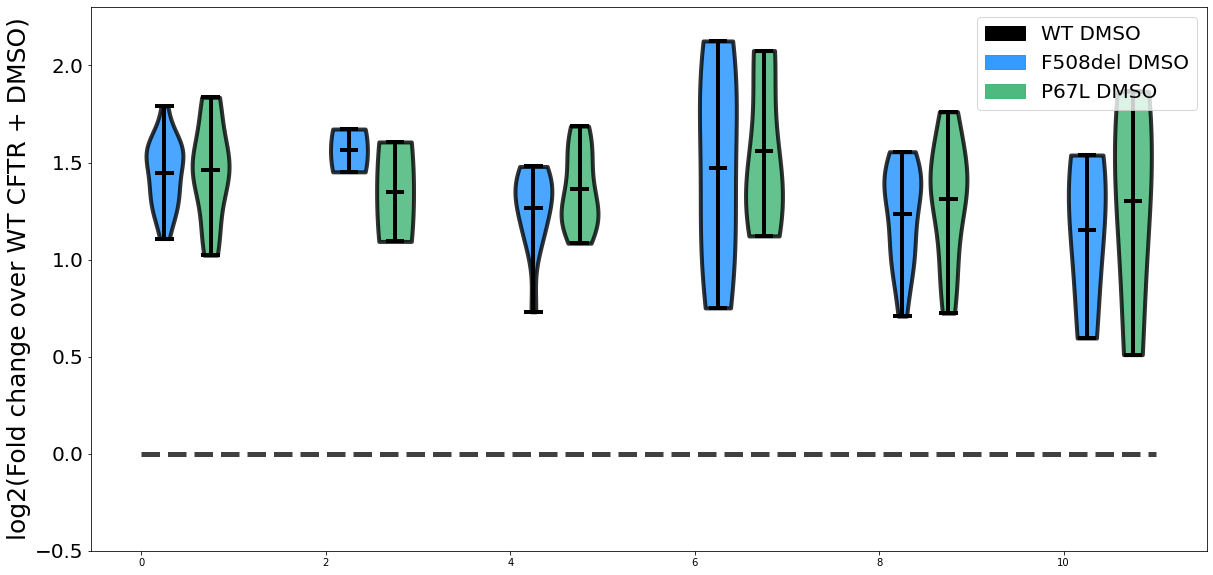

In [245]:
plt.figure(figsize=(20,10))
x0 = 'F508del DMSO'
x1 = 'P67L DMSO'

plt.hlines(0,0,11, ls='--', lw=5, color='k', alpha=0.75)

#paths = [transla_df, transloc_df, fold_df, prot_df, auto_df, endo_df, traff_df, MO_df,deg_df, cyto_df, ion_df]
paths = [  transla_df, fold_df, prot_df, auto_df, traff_df, endo_df]
plt0 = [i[x0] for i in paths]
plt1 = [i[x1] for i in paths]


violin_parts0 = plt.violinplot(plt0,np.array([i*2 for i in np.arange(0,len(plt1))]) + .25 ,widths =.4, showmeans=1)

violin_parts1 = plt.violinplot(plt1,np.array([i*2 for i in np.arange(0,len(plt1))]) + .75 ,widths =.4, showmeans=1)

plt.setp(violin_parts0['cmaxes'], color='k', linewidth =4)
plt.setp(violin_parts0['cmeans'], color='k', linewidth =4)
plt.setp(violin_parts0['cmins'], color='k', linewidth =4)
plt.setp(violin_parts0['cbars'], color='k', linewidth =4)
plt.setp(violin_parts0['bodies'], facecolor ='dodgerblue', edgecolor='k', alpha=0.8, linewidth =4)

plt.setp(violin_parts1['cmaxes'], color='k', linewidth =4)
plt.setp(violin_parts1['cmeans'], color='k', linewidth =4)
plt.setp(violin_parts1['cmins'], color='k', linewidth =4)
plt.setp(violin_parts1['cbars'], color='k', linewidth =4)
plt.setp(violin_parts1['bodies'], facecolor ='mediumseagreen', edgecolor='k', alpha=0.8, linewidth =4)

leg0 = mpatches.Patch(color='k', label='WT DMSO')
leg1 = mpatches.Patch(color='dodgerblue', label=x0, alpha=0.9)
leg2 = mpatches.Patch(color='mediumseagreen', label=x1, alpha=0.9)

plt.legend(handles=[leg0, leg1, leg2], fontsize=20)
plt.ylim(-0.5, 2.3)


plt.ylabel('log2(Fold change over WT CFTR + DMSO)', fontsize=25)
plt.yticks(size=20)

#plt.savefig('../Figures/Fig3_violin_plot_v2.svg', format='svg')
plt.show()

## Revisions Request 

In [241]:
set(to_heatmap_paths['pathway'])

{'Apoptosis',
 'Autophagy',
 'CFTR',
 'Calcium Signaling ',
 'Calcium signaling',
 'Cell adhesion',
 'Cytoskeleton',
 'DNA Binding',
 'DNA repair',
 'DNA replication/ elongation',
 'Degradation',
 'Differentiation',
 'ER targeting',
 'Endocytosis',
 'Folding',
 'Folding ',
 'Lipid Metabolism',
 'Membrane Organization',
 'Metabolism',
 'Metal ion binding',
 'Mitochondrial function',
 'N-glycosylation',
 'Nuclear import / export',
 'Oxidative Stress Response',
 'Proteasomal',
 'RNA binding',
 'RNA processing',
 'RNA processing ',
 'RNA processing/ RNA silencing',
 'RNA-binding',
 'Signaling',
 'Trafficking',
 'Transcription',
 'Translation',
 'Translocation',
 'Uncharacterized',
 'Uncharacterized / Unclear',
 'post translational modification'}

In [372]:

df1=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Apoptosis']
df2=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Calcium signaling']
df3=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Cell adhesion']
df4=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Cytoskeleton']
df5=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'DNA Binding']
df6=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'DNA repair']

df7=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'DNA replication/ elongation']
df8=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Differentiation']
df9=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'ER targeting']
df10=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Lipid Metabolism']
df11=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Metabolism']
df12=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Metal ion binding']

df13=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'N-glycosylation']
df14=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Nuclear import / export']
df15=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Oxidative Stress Response']
df16=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'RNA binding']
df17=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'RNA processing']
df18=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'RNA processing/ RNA silencing']

df19=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'RNA-binding']
df20=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Signaling']
df21=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Oxidative Stress Response']
df22=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Transcription']
df23=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Uncharacterized']
df24=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'post translational modification']


In [649]:
paths_dict = {'1': df1, '2': df2, '3': df3, '4': df4,'5': df5, '6': df6,
              '7': df7, '8': df8, '9': df9, '10': df10, '11': df11,'12': df12,
              '13': df13, '14': df14, '15': df15, '16': df16, '17': df17,'18': df18,
              '19': df19, '20': df20, '21': df21, '22': df22, '23': df23,'24': df24,}

In [469]:
from scipy.stats import gaussian_kde

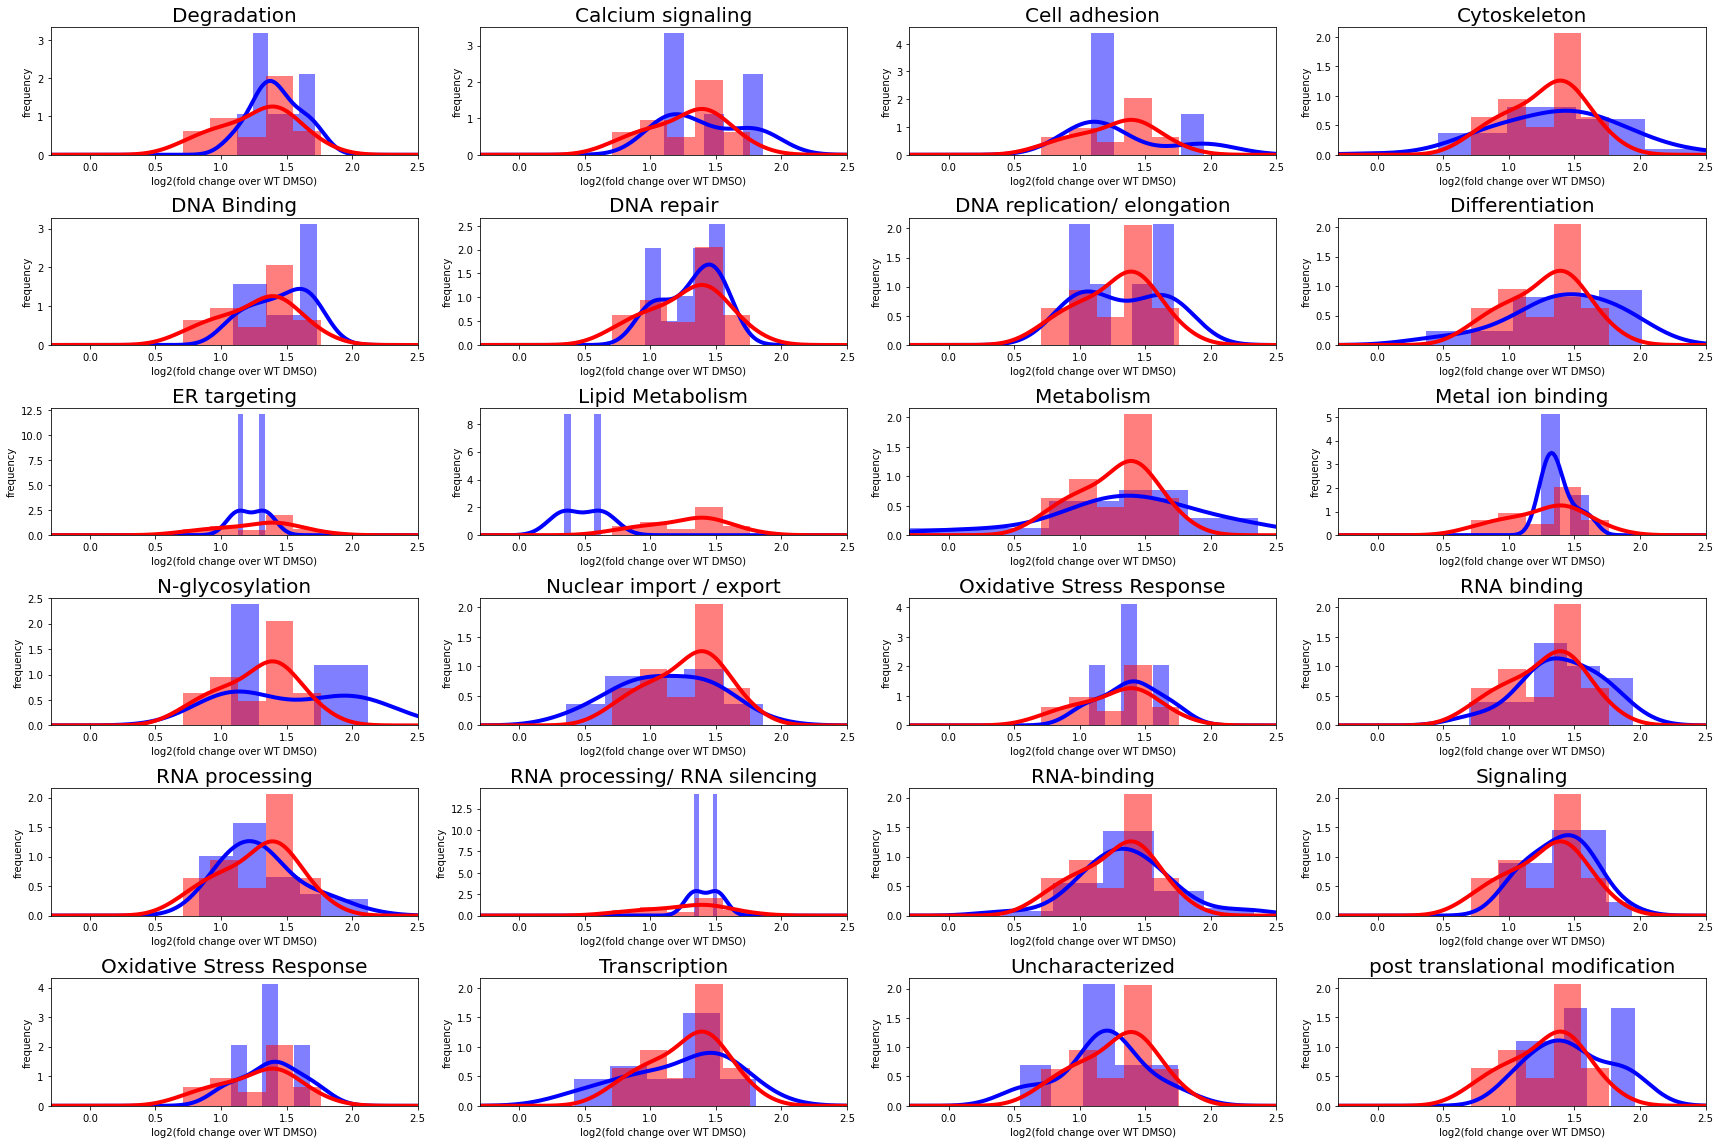

In [659]:
fig, axs = plt.subplots(6, 4, tight_layout=True)
fig.set_figheight(16)
fig.set_figwidth(24)
bin_num = 5
count = 0
for i in [0,1,2,3,4,5,]:
    for j in [0,1,2,3]:
        count +=1
        axs[i,j].set_xlim([-0.3, 2.5])
        #ax[i,j].set_ylim([0, 5])
        axs[i,j].set_title(paths_dict[str(count)]['pathway'][0], size=20)
        #axs[i,j].hist(paths_dict[str(count)]['F508del DMSO'],          
         #             bins=bin_num, color='blue', density=True, alpha=1)
        #axs[i,j].hist(fold_df['F508del DMSO'], bins=bin_num, color='red', density=True, alpha=0.5)
        axs[i,j].set_xlabel('log2(fold change over WT DMSO)')
        axs[i,j].set_ylabel('frequency')
                
        data1 = np.concatenate([paths_dict[str(count)]['F508del DMSO'], paths_dict[str(count)]['P67L DMSO']])
        density1 = gaussian_kde(data1)
        xrng = np.linspace(-0.5,2.5,200)
        density1.covariance_factor = lambda : .6
        density1._compute_covariance()
        
        data2 = np.concatenate([traff_df['F508del DMSO'], traff_df['P67L DMSO']])
        density2 = gaussian_kde(data2)
        xrng = np.linspace(-0.5,2.5,200)
        density2.covariance_factor = lambda : .6
        density2._compute_covariance()
        
        axs[i,j].plot(xrng, density1(xrng), color = 'blue', lw=4)
        axs[i,j].plot(xrng, density2(xrng), color = 'red', lw=4)
        
        axs[i,j].hist(data1,bins=bin_num, color='blue', density=True, alpha=0.5)
        axs[i,j].hist(data2,bins=bin_num, color='red', density=True, alpha=0.5)


plt.show()

In [509]:
cyto_df=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Cytoskeleton']
diff_df=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Differentiation']
meta_df=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Metabolism']
nuc_df=to_heatmap_paths.loc[to_heatmap_paths['pathway'] == 'Nuclear import / export']

In [517]:
paths_dict = {'1': cyto_df, '2': diff_df, '3': meta_df, '4': nuc_df}

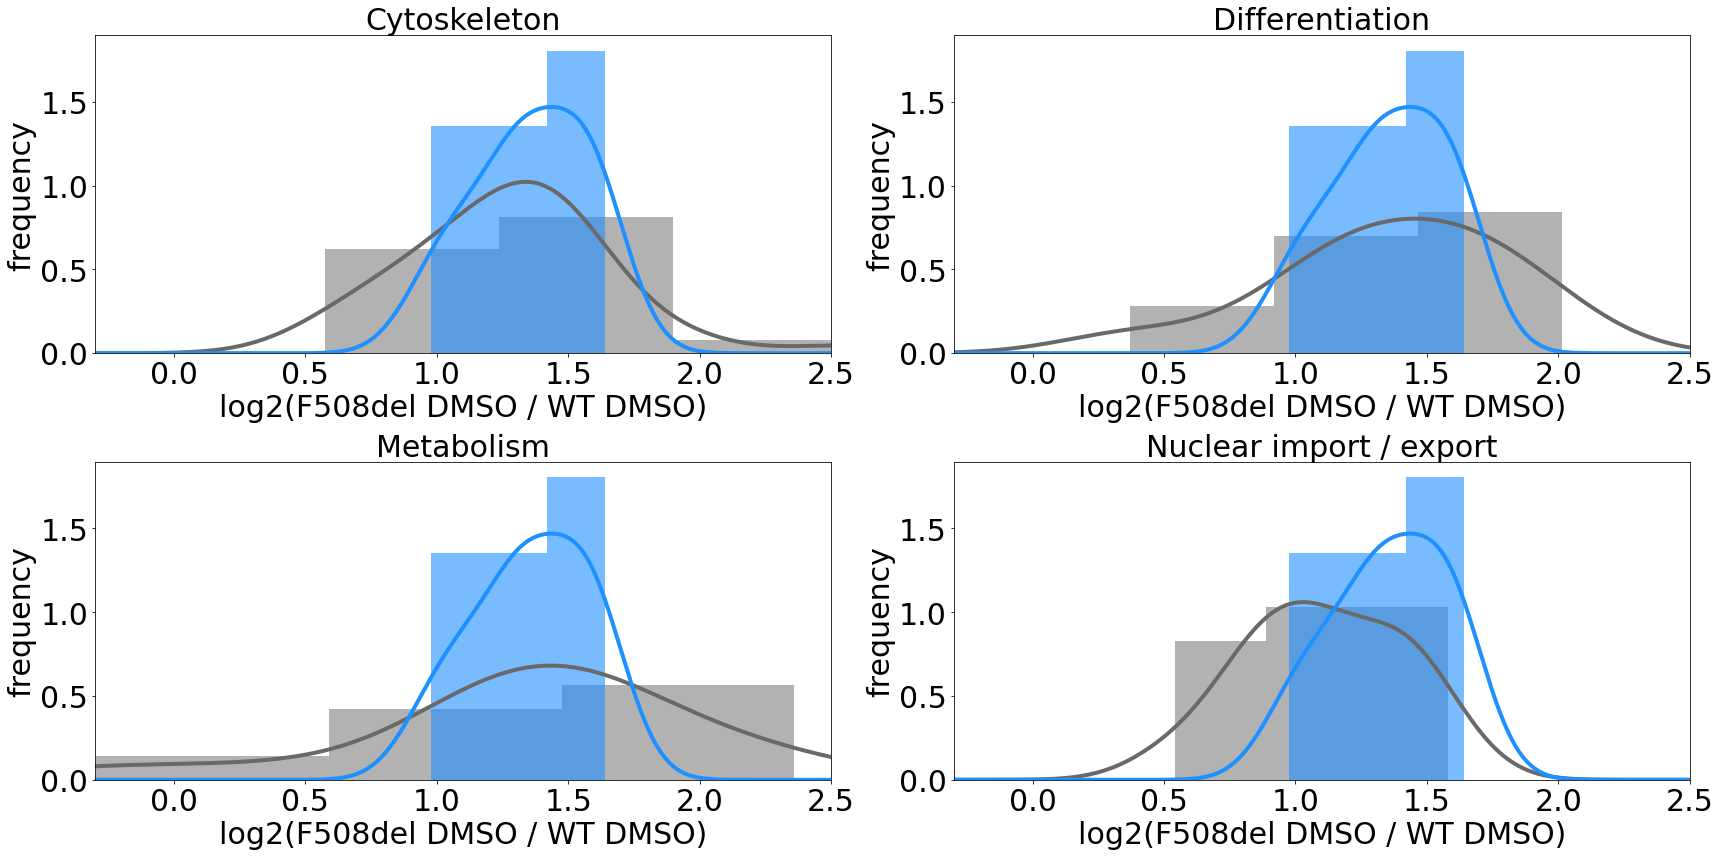

In [547]:
fig, axs = plt.subplots(2, 2, tight_layout=True)
fig.set_figheight(12)
fig.set_figwidth(24)
fig.tight_layout(pad=10)
bin_num = 3
count = 0
for i in [0,1]:
    for j in [0,1]:
        count +=1
        axs[i,j].set_xlim([-0.3, 2.5])
        axs[i,j].set_title(paths_dict[str(count)]['pathway'][0], size=30)
        axs[i,j].set_xlabel('log2(F508del DMSO / WT DMSO)', size=30)
        axs[i,j].set_ylabel('frequency', size=30)
        axs[i,j].tick_params('both',  labelsize=30)
                
        data1 = paths_dict[str(count)]['F508del DMSO']
        density1 = gaussian_kde(data1)
        xrng = np.linspace(-0.5,2.5,200)
        density1.covariance_factor = lambda : .6
        density1._compute_covariance()
        
        data2 = fold_df['F508del DMSO']
        density2 = gaussian_kde(data2)
        xrng = np.linspace(-0.5,2.5,200)
        density2.covariance_factor = lambda : .6
        density2._compute_covariance()
        
        axs[i,j].plot(xrng, density1(xrng), color = 'dimgrey', lw=4)
        axs[i,j].plot(xrng, density2(xrng), color = 'dodgerblue', lw=4)
        
        axs[i,j].hist(data1,bins=bin_num, color='grey', density=True, alpha=0.6)
        axs[i,j].hist(data2,bins=bin_num, color='dodgerblue', density=True, alpha=0.6)


#plt.savefig('../Figures/Supplemental/F508del_not_CF_pathway_upregulation.svg', format='svg')
plt.show()

In [305]:
prot_df.to_excel('../Supplemental_Materials/Pathway_anaylsis_excels/proteasomal_degradation.xlsx')

In [306]:
auto_df.to_excel('../Supplemental_Materials/Pathway_anaylsis_excels/autophagy_degradation.xlsx')

In [307]:
fold_df.to_excel('../Supplemental_Materials/Pathway_anaylsis_excels/folding.xlsx')

In [308]:
transla_df.to_excel('../Supplemental_Materials/Pathway_anaylsis_excels/translation.xlsx')
endo_df.to_excel('../Supplemental_Materials/Pathway_anaylsis_excels/endocytosis.xlsx')
traff_df.to_excel('../Supplemental_Materials/Pathway_anaylsis_excels/trafficking.xlsx')

In [309]:
transloc_df.to_excel('../Supplemental_Materials/Pathway_anaylsis_excels/translocation.xlsx')

In [310]:
deg_df.to_excel('../Supplemental_Materials/Pathway_anaylsis_excels/degradation.xlsx')

In [311]:
MO_df.to_excel('../Supplemental_Materials/Pathway_anaylsis_excels/membrane_organization.xlsx')

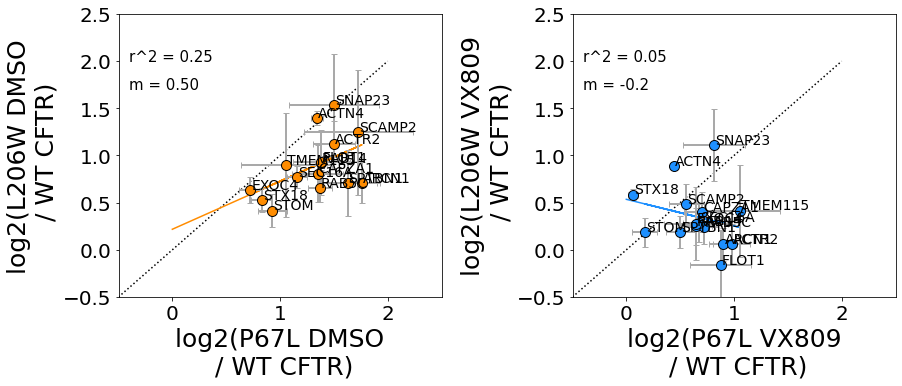

In [646]:
x = 'P67L DMSO'
y = 'L206W DMSO'

x1 = 'P67L VX809'
y1 = 'L206W VX809'

nx1 = len(P67L_DMSO)
ny1 = len(L206W_DMSO)

nx2 = len(P67L_VX809)
ny2 = len(L206W_VX809)


df = traff_df


fig,ax = plt.subplots(1,2, figsize=(14,7))
fig.tight_layout(pad=10.0)

ax[0].plot([-1,0,1,2],[-1,0,1,2], color='k', ls=':', zorder=-2)
ax[1].plot([-1,0,1,2],[-1,0,1,2], color='k', ls=':', zorder=-2)
fontsize =25

idx = np.isfinite(df[y]) & np.isfinite(df[y])
m,b = np.polyfit(df[x][idx], df[y][idx], 1)


idx1 = np.isfinite(df[y]) & np.isfinite(df[y1])
m1,b1 = np.polyfit(df[x1][idx1], df[y1][idx1], 1)

r2 = df[[x, y]].corr('pearson').values[0,1]**2
r2_1 = df[[x1, y1]].corr('pearson').values[0,1]**2

ax[0].scatter(df[x], df[y] , color='darkorange', edgecolor='k', s=100, zorder=1)
ax[0].errorbar(df[x],df[y], xerr=df[x + ' std']/np.sqrt(nx1), yerr = df[x + ' std']/np.sqrt(ny1),
             ls='none', ecolor='darkgrey', elinewidth=2, capsize=3, zorder=0 )
ax[0].plot(np.concatenate([[0.0],df[x]]), m*np.concatenate([[0],df[x]]) + b, color='darkorange', ls='-', zorder=-1)
ax[0].text(-0.4,2,'r^2 = '+ str(r2)[:4], size=fontsize-10)
ax[0].text(-0.4,1.7,'m = '+ str(m)[:4], size=fontsize-10)

ax[1].scatter(df[x1], df[y1] , color='dodgerblue', edgecolor='k', s=100, zorder=1)
ax[1].errorbar(df[x1],df[y1], xerr=df[x1 + ' std']/np.sqrt(nx2), yerr = df[x1 + ' std']/np.sqrt(ny2),
             ls='none', ecolor='darkgrey', elinewidth=2, capsize=3, zorder=0 )
ax[1].plot(np.concatenate([[0.0],df[x1]]), m1*np.concatenate([[0],df[x1]]) + b1, color='dodgerblue', ls='-', zorder=-1)
ax[1].text(-0.4,2,'r^2 = '+ str(r2_1)[:4], size=fontsize-10)
ax[1].text(-0.4,1.7,'m = '+ str(m1)[:4], size=fontsize-10)



for i in df.index:

    ax[0].text(df.loc[i][x]+0.01, df.loc[i][y]+0.01, i, size=14)
    ax[1].text(df.loc[i][x1]+0.01, df.loc[i][y1]+0.01, i, size=14)

ax[0].set_xlabel('log2('+ x + '\n / WT CFTR)', size=fontsize)
ax[0].set_ylabel('log2('+ y + '\n / WT CFTR)', size=fontsize)
ax[0].set_xlim(-0.5,2.5)
ax[0].set_ylim(-0.5,2.5)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize-5)

ax[1].set_xlabel('log2('+ x1 + '\n / WT CFTR)', size=fontsize)
ax[1].set_ylabel('log2('+ y1 + '\n / WT CFTR)', size=fontsize)
ax[1].set_xlim(-0.5,2.5)
ax[1].set_ylim(-0.5,2.5)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize-5)


plt.savefig('../Figures/correlation_plots/P67L_L206W_trafficking.svg', format='svg')


In [549]:
len(P67L_DMSO)

12

r^2 = 0.010041419465663316
m = 0.14358973638436454


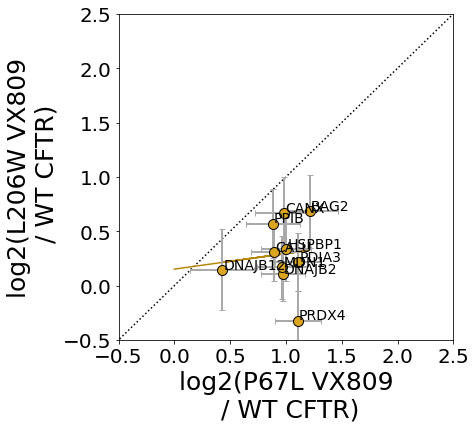

In [596]:
x = 'P67L VX809'
y = 'L206W VX809'
nx = len(P67L_DMSO)
ny = len(L206W_DMSO)
df = translat_df


plt.figure(figsize=(6,6))
plt.plot([-1,0,1,2.5],[-1,0,1,2.5], color='k', ls=':', zorder=-2)
fontsize =25

idx = np.isfinite(df[y]) & np.isfinite(df[y])
m,b = np.polyfit(df[x][idx], df[y][idx], 1)


plt.scatter(df[x], df[y] , color='goldenrod', edgecolor='k', s=100, zorder=1)
plt.errorbar(df[x],df[y], xerr=df[x + ' std']/np.sqrt(nx), yerr = df[x + ' std']/np.sqrt(ny),
             ls='none', ecolor='darkgrey', elinewidth=2, capsize=3, zorder=0 )


plt.plot(np.concatenate([[0.0],df[x]]), m*np.concatenate([[0],df[x]]) + b, color='darkgoldenrod', ls='-', zorder=-1)

r2 = df[[x, y]].corr('pearson').values[0,1]**2

for i in df.index:

    plt.text(df.loc[i][x]+0.01, df.loc[i][y]+0.01, i, size=14)


plt.xlabel('log2('+ x + '\n / WT CFTR)', size=fontsize)
plt.ylabel('log2('+ y + '\n / WT CFTR)', size=fontsize)
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,2.5)
plt.xticks(size=fontsize-5)
plt.yticks(size=fontsize-5)


print('r^2 = ' + str(r2))

print('m = ' + str(m))
